In [175]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import matplotlib.gridspec as gridspec

# Diccionario de colores fijos para cada opción
COLOR_MAP = {
    "Iniciales": "#90CAF9",
    "Ambos": "#42A5F5",
    "Avanzados": "#1E88E5",
    "Nada importante": "#FFEBEE",
    "Poco importante": "#FFCDD2",
    "Importante": "#EF9A9A",
    "Muy importante": "#E57373",
    "Extremadamente importante": "#D32F2F",
    "Fácil de deducir": "#FFE082",
    "Moderadamente deducible": "#FFB74D",
    "Difícil de deducir": "#F57C00",
}

def load_data(folder='encuestas'):
    """Carga todos los CSV de la carpeta 'encuestas' en un diccionario."""
    data = {}
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            path = os.path.join(folder, file)
            df = pd.read_csv(path, encoding='utf-8')
            data[file.replace('.csv', '')] = df
    return data

def prepare_data(data):
    """
    Concatena todos los CSV y filtra solo las filas de consejos (donde la columna '#' es numérica).
    Mapea los valores de las categorías para análisis.
    """
    all_data = pd.concat(data.values(), ignore_index=True)
    advice_data = all_data[all_data['#'].astype(str).str.isdigit()].copy()
    imp_map = {"Nada importante": 0, "Poco importante": 1, "Importante": 2, "Muy importante": 3, "Extremadamente importante": 4}
    diff_map = {"Fácil de deducir": 1, "Moderadamente deducible": 2, "Difícil de deducir": 3}
    appl_map = {"Iniciales": 1, "Ambos": 1.5, "Avanzados": 2}
    advice_data['Importancia Valor'] = advice_data['Importancia'].map(imp_map)
    advice_data['Dificultad Valor'] = advice_data['Dificultad de Deducción'].map(diff_map)
    advice_data['Aplicable Valor'] = advice_data['Aplicable a'].map(appl_map)
    return advice_data

def create_pie_chart(data, category, ax, radius=0.1):
    """
    Crea un gráfico de torta para la categoría indicada.
    Si la etiqueta tiene 2 o 3 palabras, se divide en dos líneas.
    """
    counts = data[category].value_counts()
    ordered = pd.Series({k: counts.get(k, 0) for k in COLOR_MAP if k in counts.index})
    labels = ordered.index
    sizes = ordered.values
    colors = [COLOR_MAP[label] for label in labels]
    formatted = []
    for label in labels:
        words = label.split()
        if len(words) == 2:
            formatted.append(words[0] + "\n" + words[1])
        elif len(words) == 3:
            formatted.append(words[0] + " " + words[1] + "\n" + words[2])
        else:
            formatted.append(label)
    ax.pie(sizes, labels=formatted, autopct='%1.1f%%', startangle=140,
           colors=colors, radius=radius, textprops={'fontsize':10})

    value_cols = {
        "Importancia": "Importancia Valor",
        "Dificultad de Deducción": "Dificultad Valor",
        "Aplicable a": "Aplicable Valor"
    }
    if category in value_cols and value_cols[category] in data.columns:
        avg = data[value_cols[category]].mean()
        ax.set_title(f"{category} (promedio: {avg:.1f})", fontsize=12, pad=10)
    else:
        ax.set_title(category, fontsize=12, pad=10)
    ax.axis('equal')

def plot_four_quadrants(data, title, consejo_text=""):
    """
    Divide la figura en 4 cuadrantes:
      - Cuadrante superior izquierdo: Muestra el texto del consejo y, si existe, los comentarios.
      - Cuadrante superior derecho: Gráfico de torta de "Importancia".
      - Cuadrante inferior izquierdo: Gráfico de torta de "Aplicable a".
      - Cuadrante inferior derecho: Gráfico de torta de "Dificultad de Deducción".
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    
    # Cuadrante superior izquierdo: Texto del consejo y comentarios
    axes[0,0].axis('off')
    advice_str = "Consejo:\n" + "\n".join(textwrap.wrap(consejo_text, width=54)) if consejo_text else "Sin consejo."
    if 'Comentarios' in data.columns:
        comments = data['Comentarios'].dropna().unique()
        if len(comments) > 0:
            advice_str += "\n\nComentarios:\n" + "\n".join(textwrap.wrap(" | ".join(comments), width=54))
    axes[0,0].text(0.5, 0.5, advice_str, ha='center', va='center', fontsize=13, wrap=True, color="#666666")
    
    # Cuadrante superior derecho: Gráfico de torta de Importancia
    create_pie_chart(data, 'Importancia', axes[0,1], radius=0.1)
    
    # Cuadrante inferior izquierdo: Gráfico de torta de Aplicable a
    create_pie_chart(data, 'Aplicable a', axes[1,0], radius=0.1)
    
    # Cuadrante inferior derecho: Gráfico de torta de Dificultad de Deducción
    create_pie_chart(data, 'Dificultad de Deducción', axes[1,1], radius=0.1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_top10_advice(advice_data, metric, extreme="highest"):
    """
    Agrupa los consejos, ordena según la métrica dada y plotea los top 10
    usando la función plot_four_quadrants. El título de cada figura indica el ranking y el número de consejo.
    """
    aggregated = advice_data.groupby('#').agg({
        'Importancia Valor': 'mean',
        'Dificultad Valor': 'mean',
        'Aplicable Valor': 'mean'
    }).reset_index()
    aggregated.rename(columns={
        'Importancia Valor': 'Importancia Promedio',
        'Dificultad Valor': 'Dificultad de Deducción Promedio',
        'Aplicable Valor': 'Aplicabilidad Promedio'
    }, inplace=True)
    if extreme == "highest":
        sorted_df = aggregated.sort_values(by=metric, ascending=False)
        metric = "mayor " + metric
    else:
        sorted_df = aggregated.sort_values(by=metric, ascending=True)
        metric = "menor " + metric
    top10 = sorted_df.head(10)
    for rank, row in enumerate(top10.itertuples(index=False), start=1):
        advice_num = row[0]
        subset = advice_data[advice_data['#'] == advice_num]
        consejo_text = subset.iloc[0]['Práctica'] if ('Práctica' in subset.columns and pd.notna(subset.iloc[0]['Práctica'])) else ""
        title_str = f"Top {rank} de {metric}: Consejo # {advice_num}"
        plot_four_quadrants(subset, title_str, consejo_text)

# Uso:
data = load_data()                      # Carga los CSVs desde la carpeta 'encuestas'
advice_data = prepare_data(data)          # Prepara el DataFrame con todas las respuestas


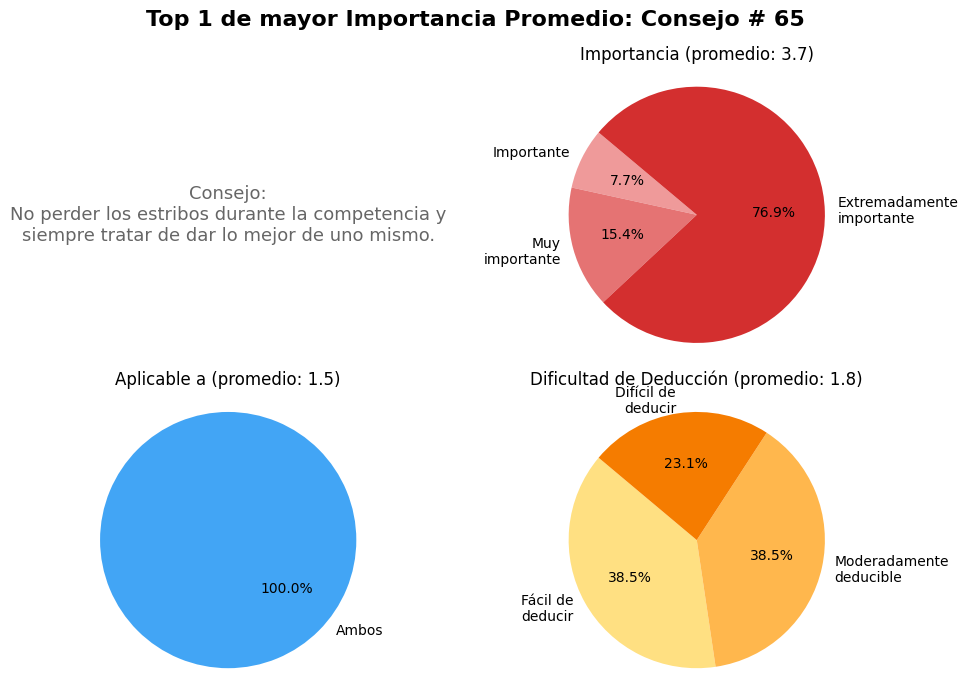

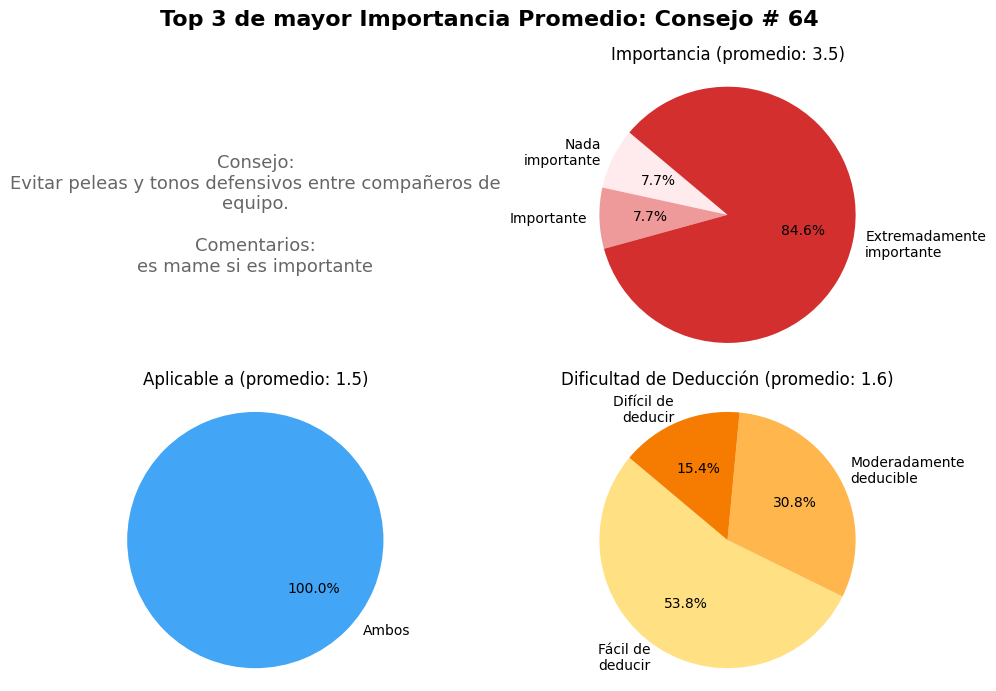

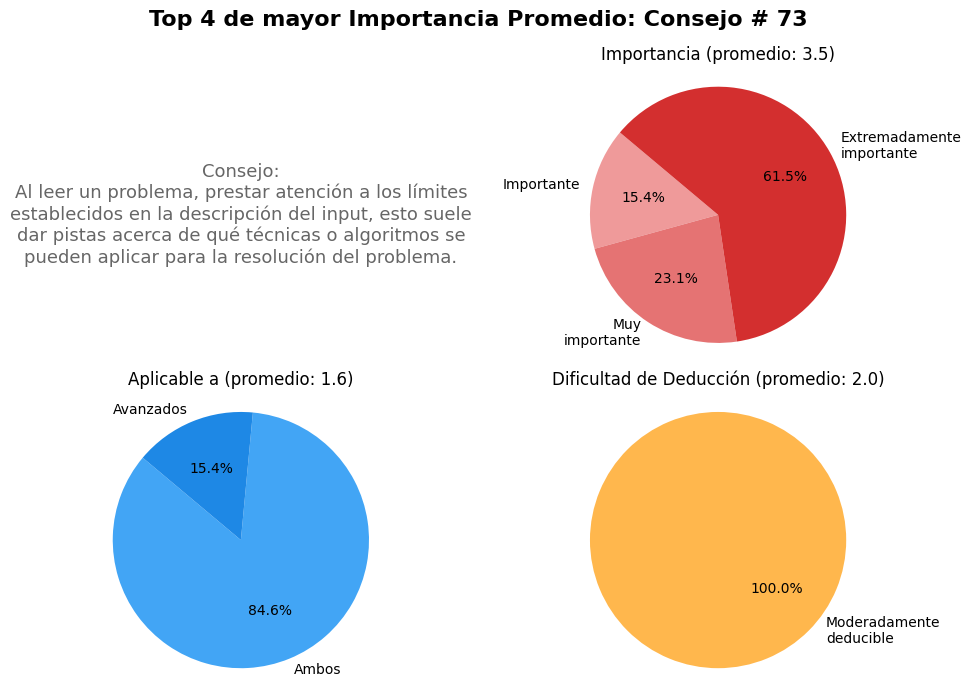

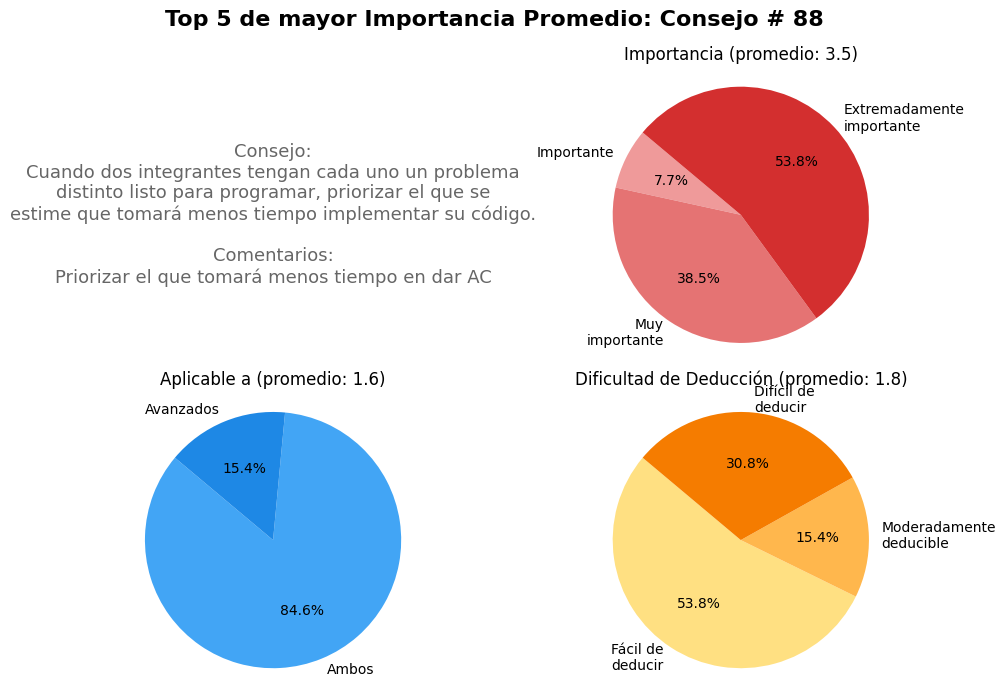

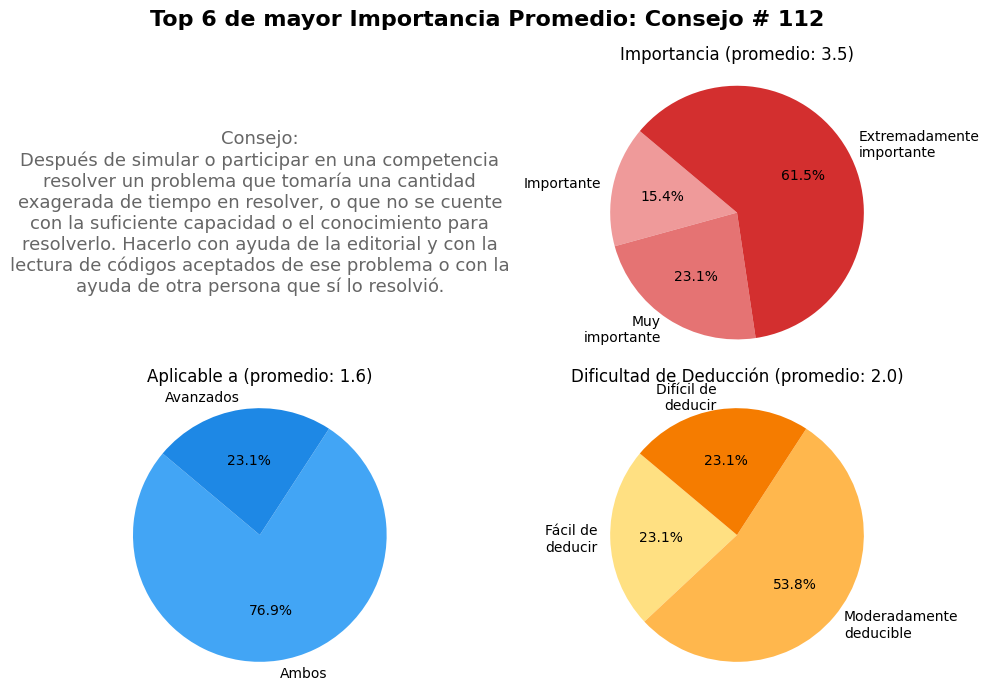

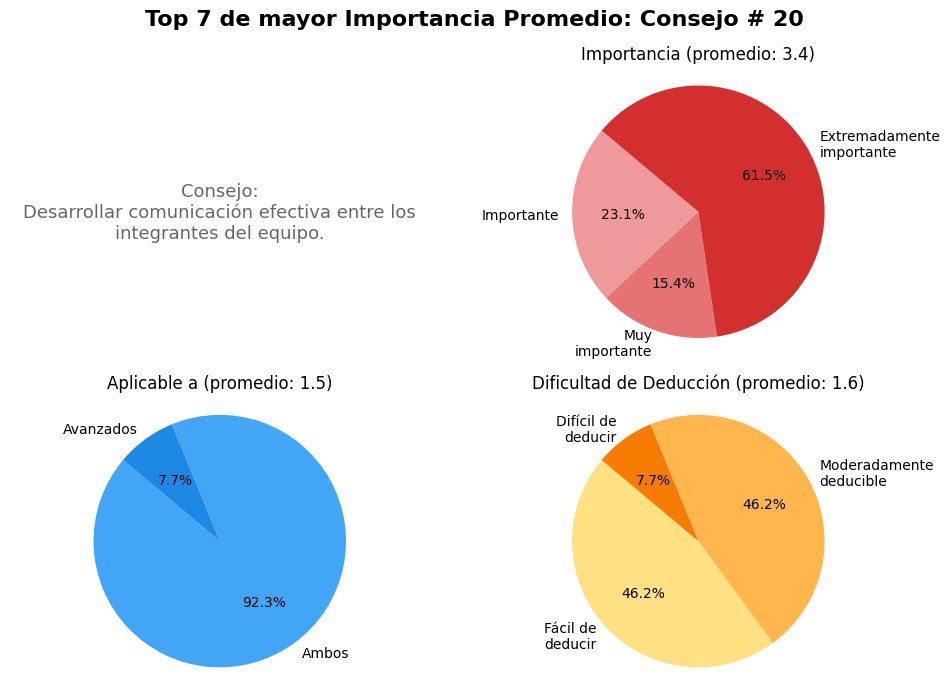

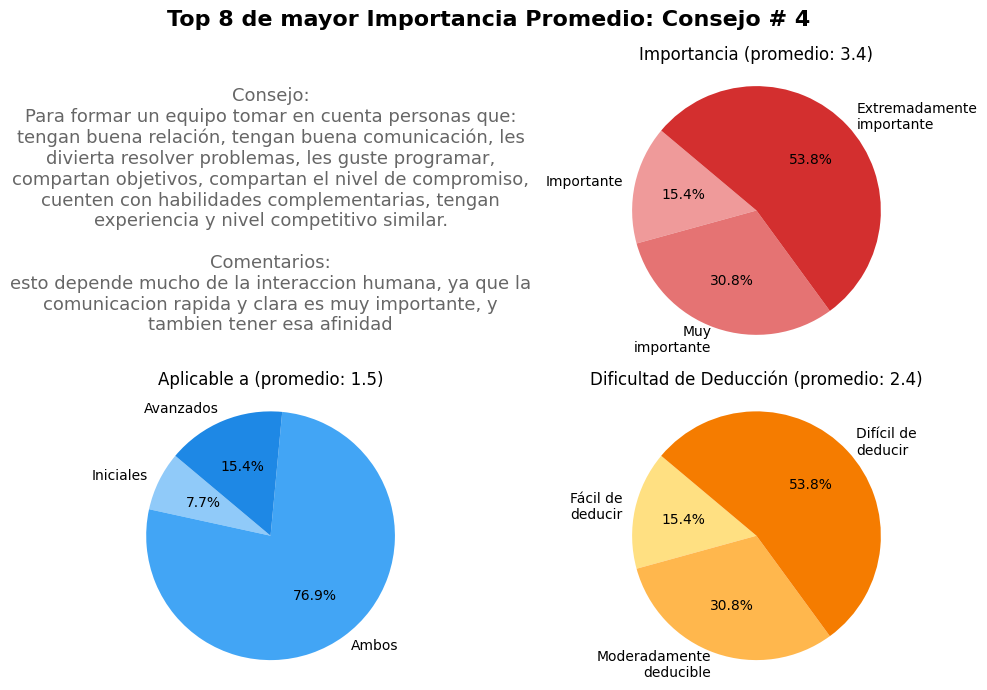

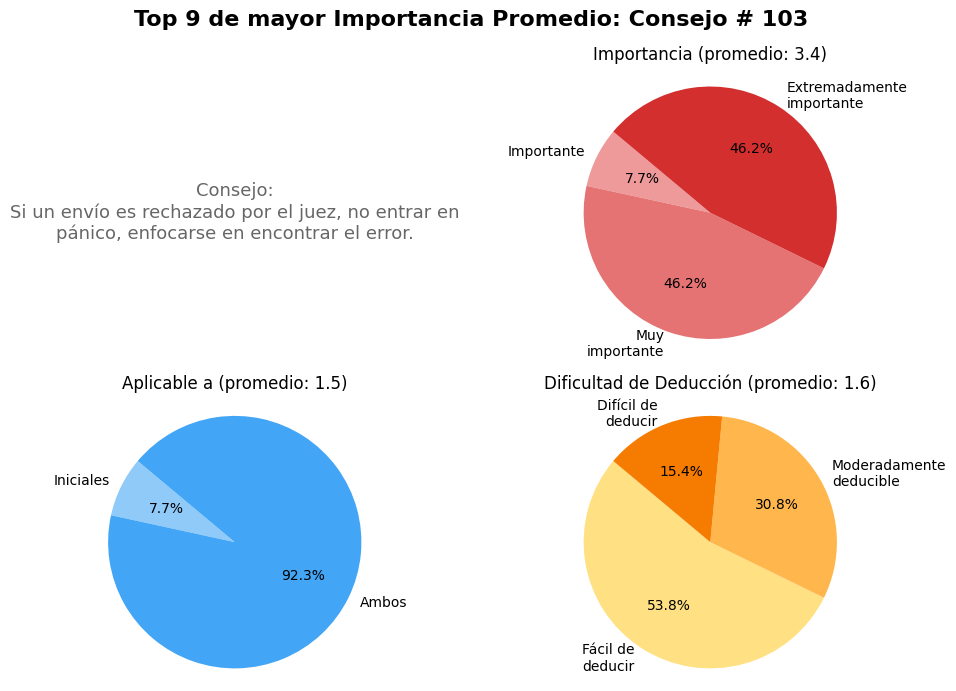

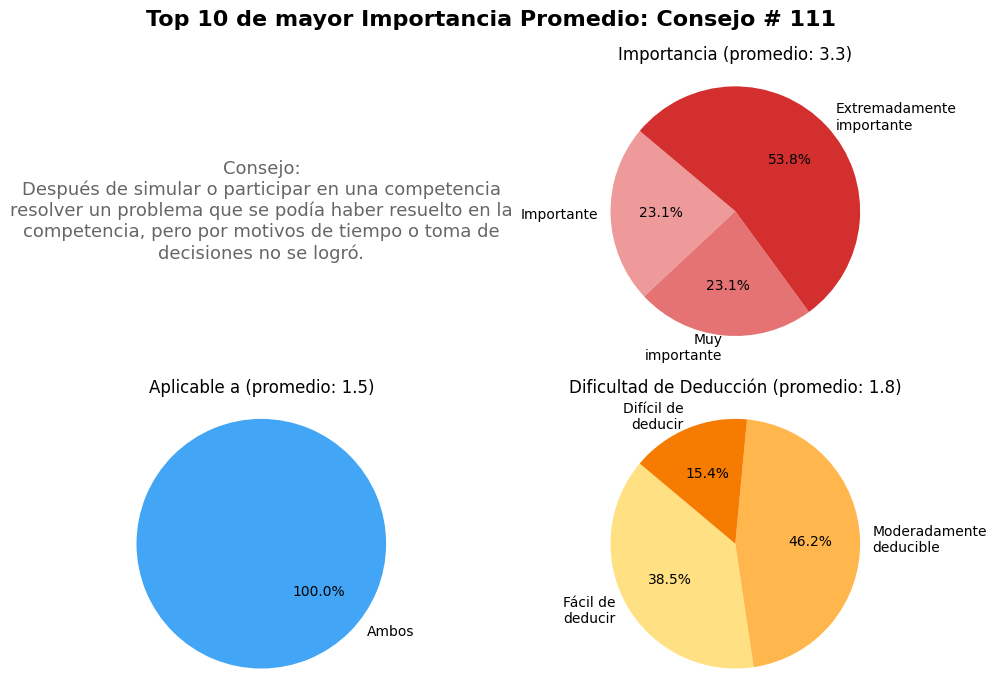

In [176]:
plot_top10_advice(advice_data, metric='Importancia Promedio', extreme="highest")

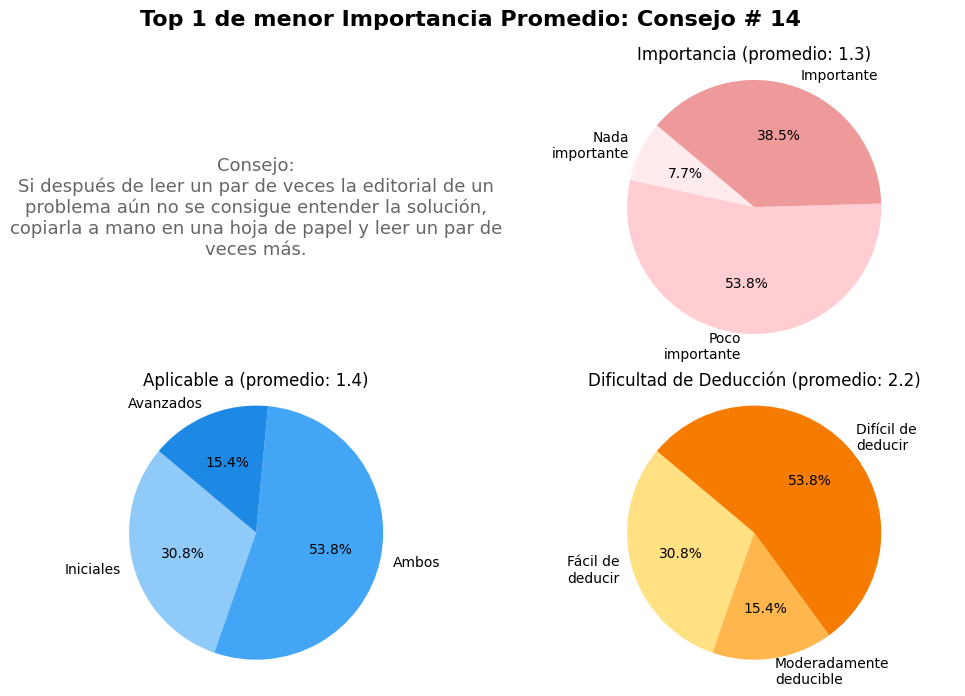

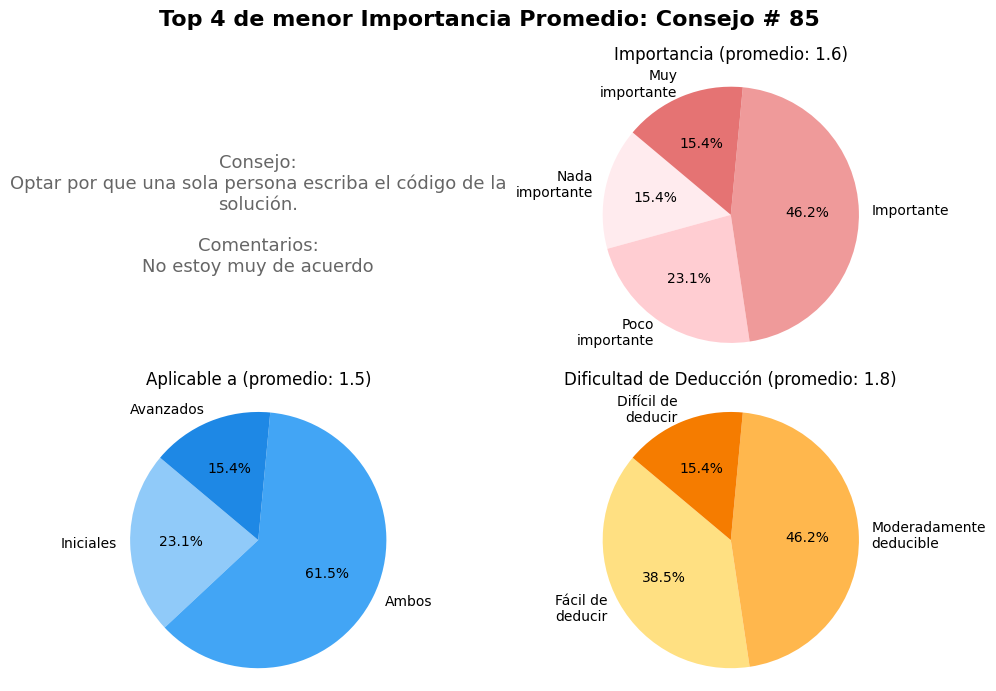

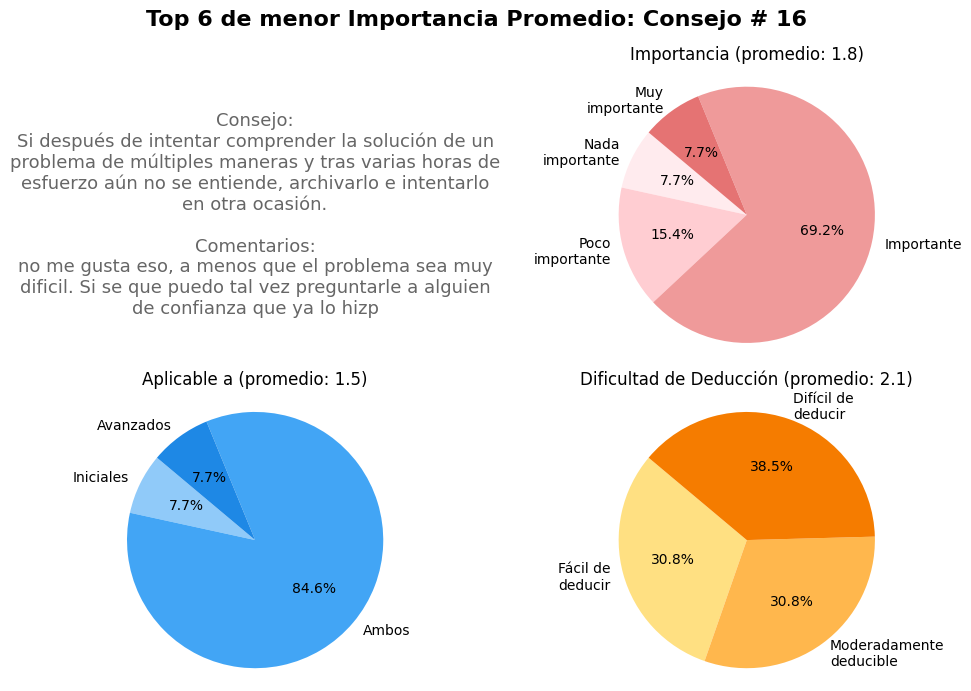

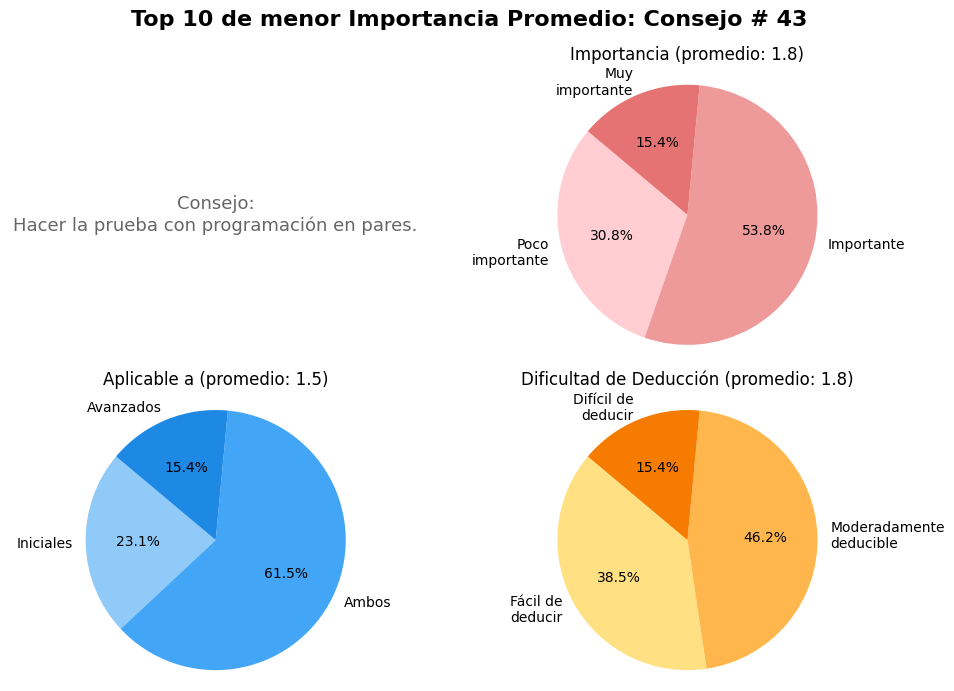

In [177]:
plot_top10_advice(advice_data, metric='Importancia Promedio', extreme="lowest")

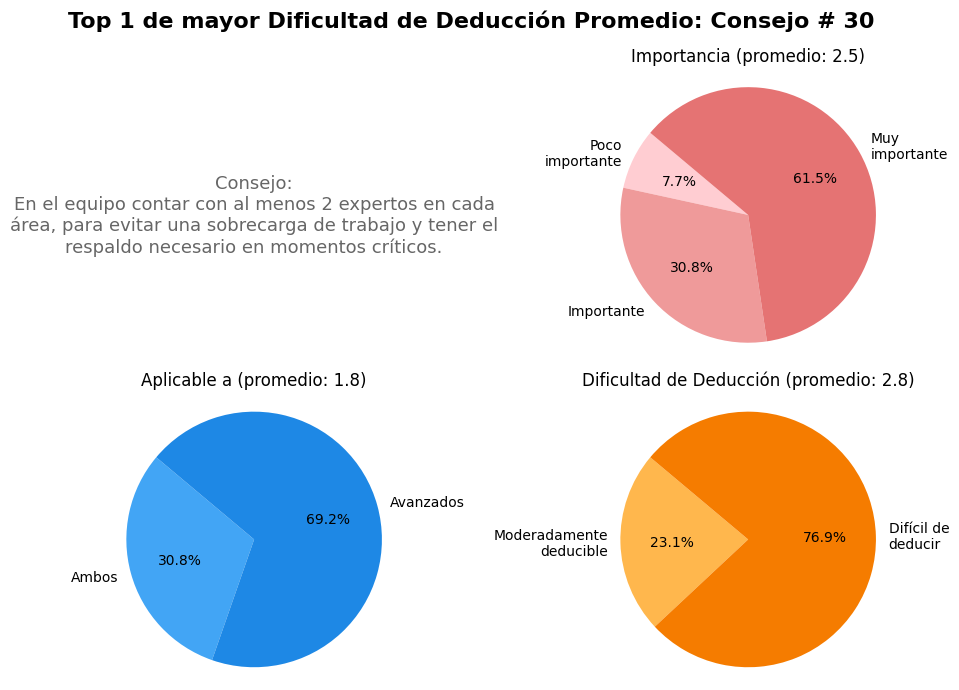

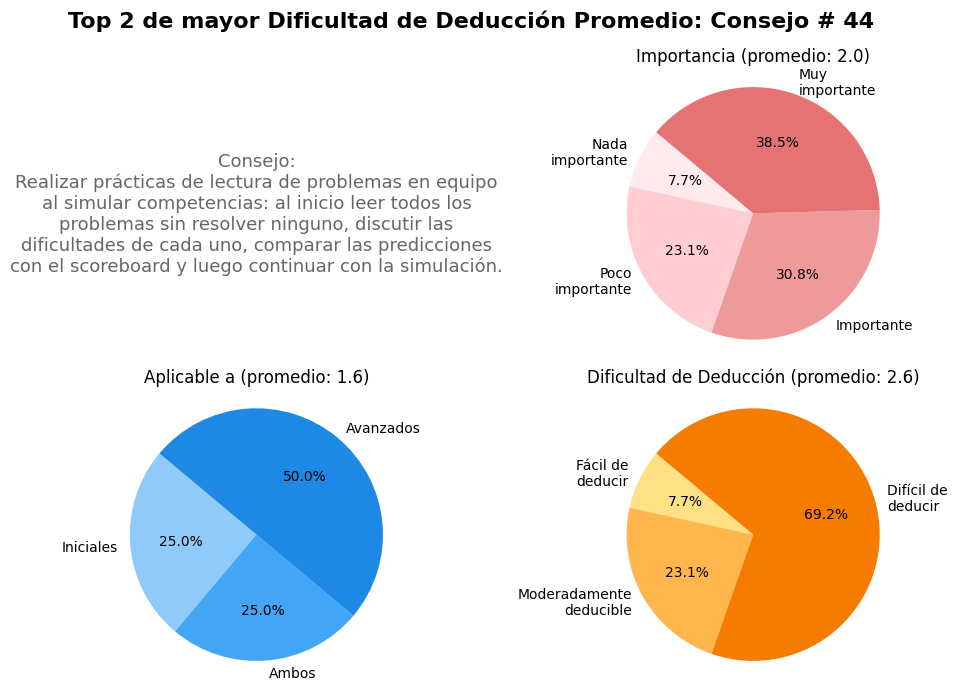

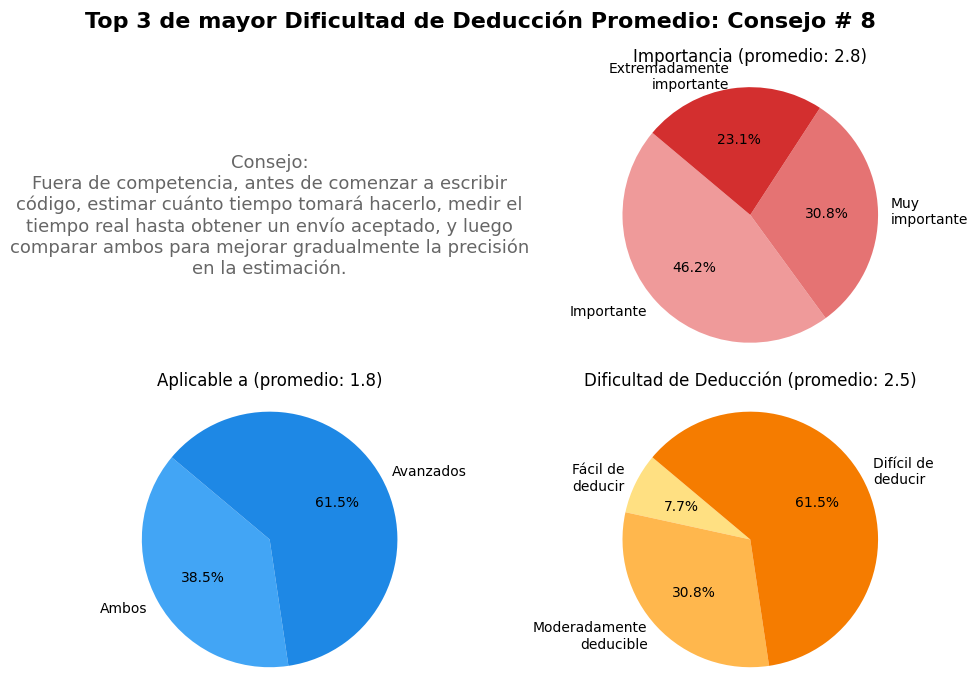

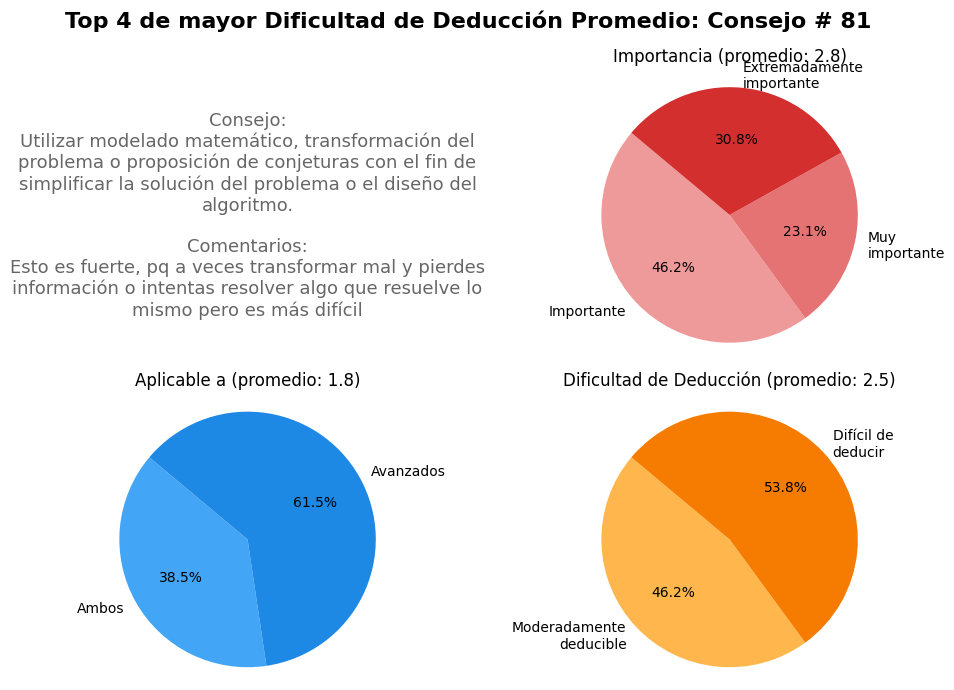

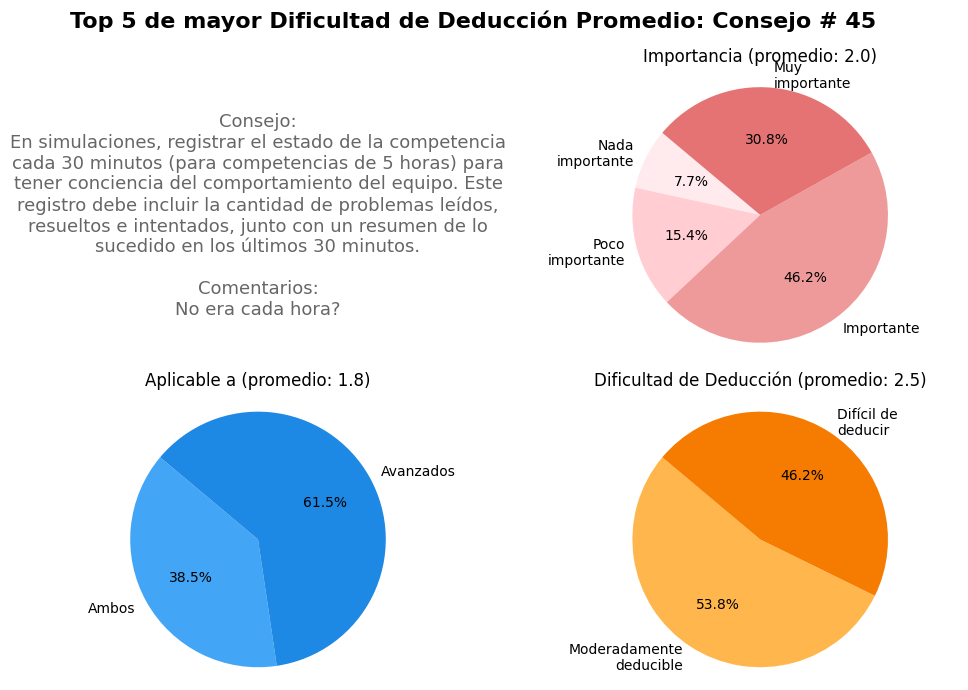

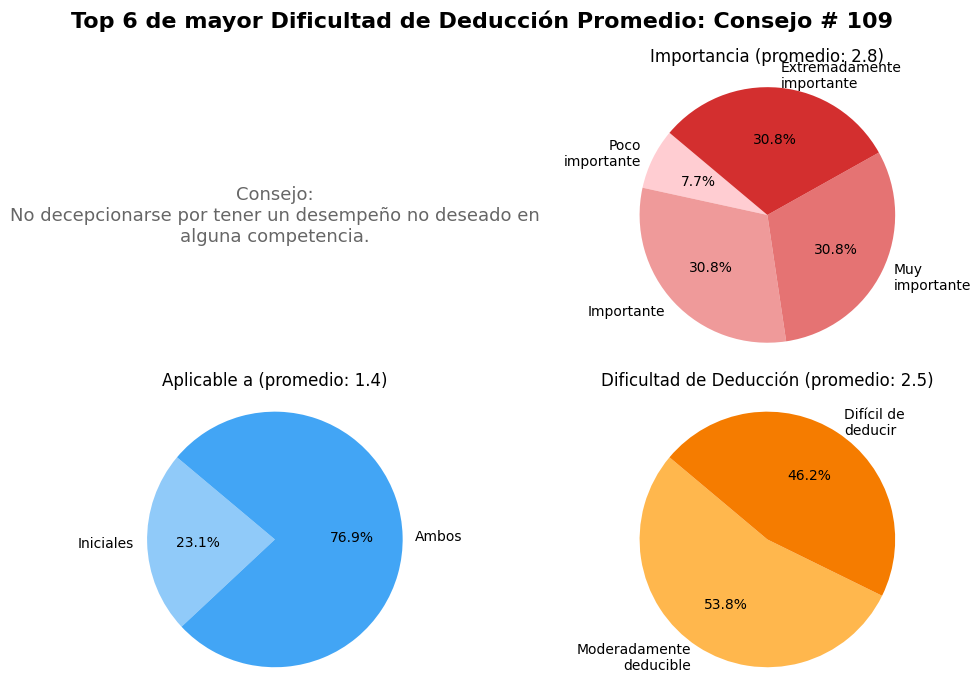

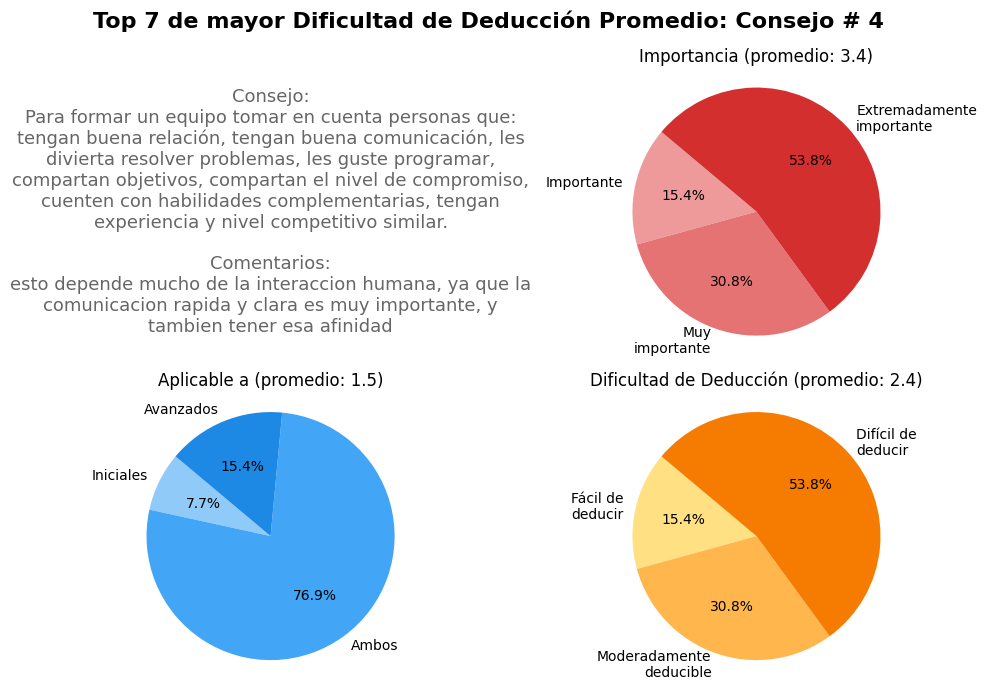

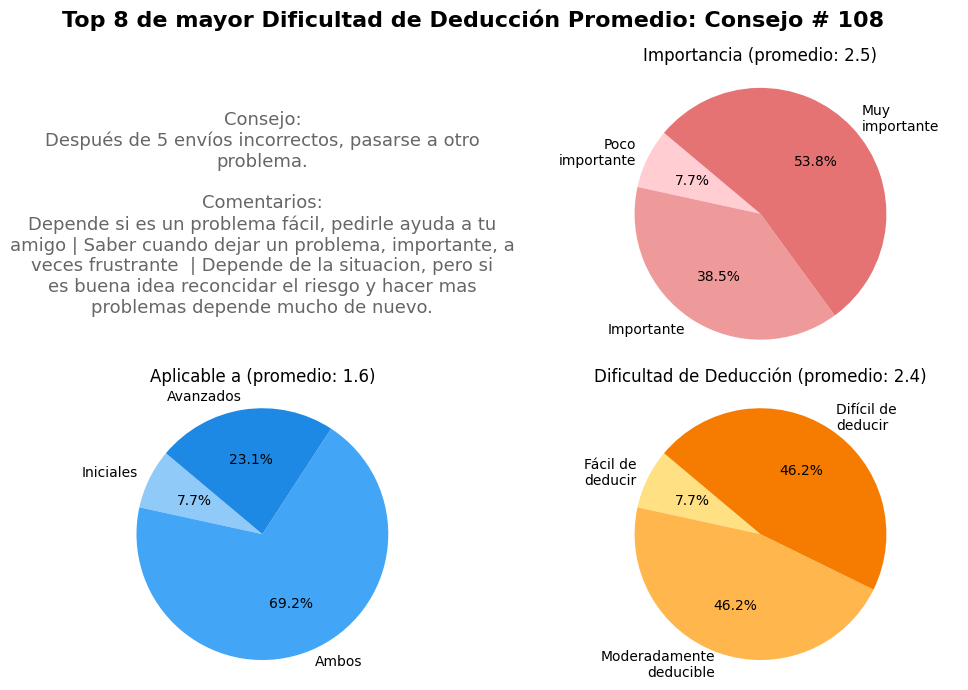

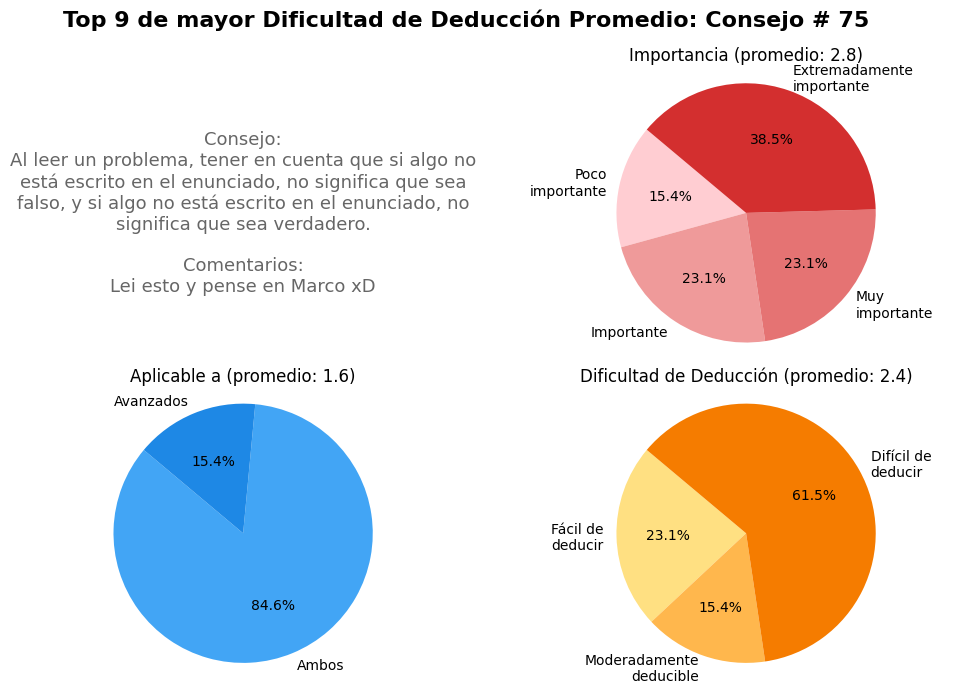

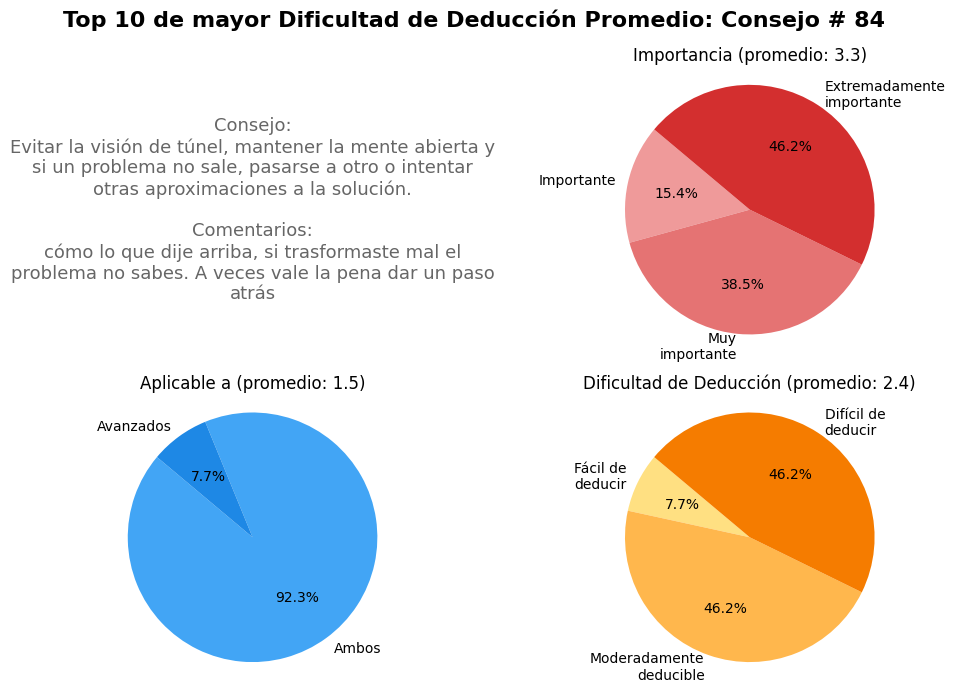

In [178]:
plot_top10_advice(advice_data, metric='Dificultad de Deducción Promedio', extreme="highest")

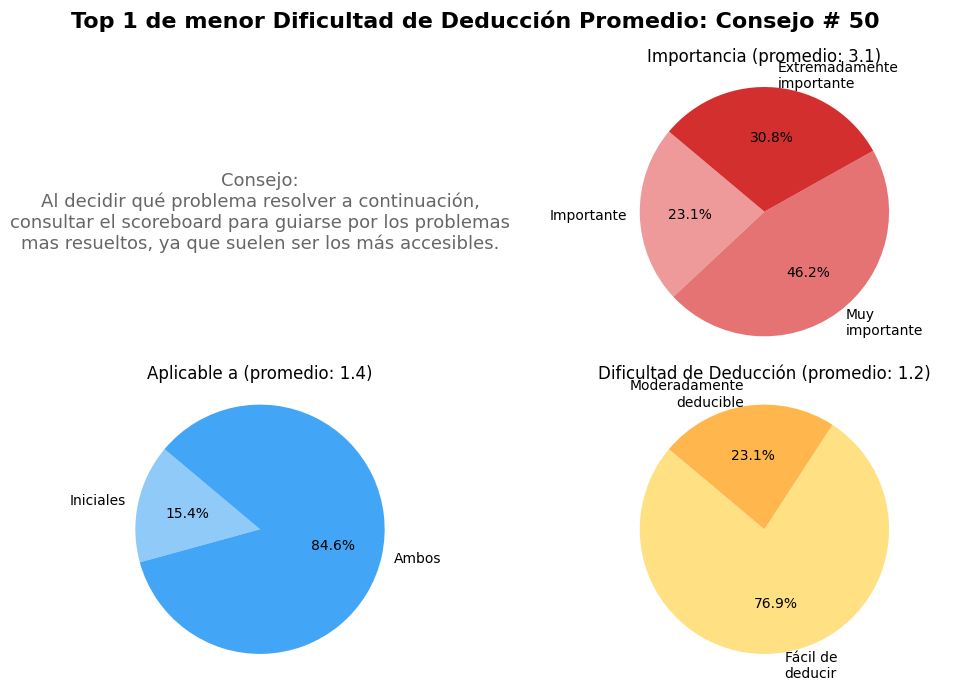

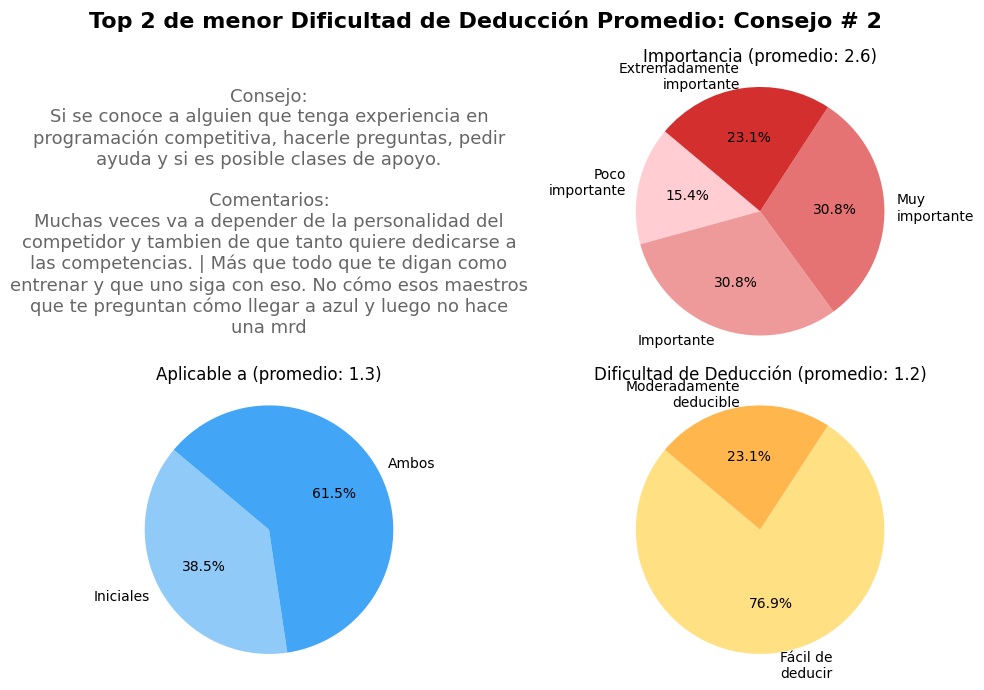

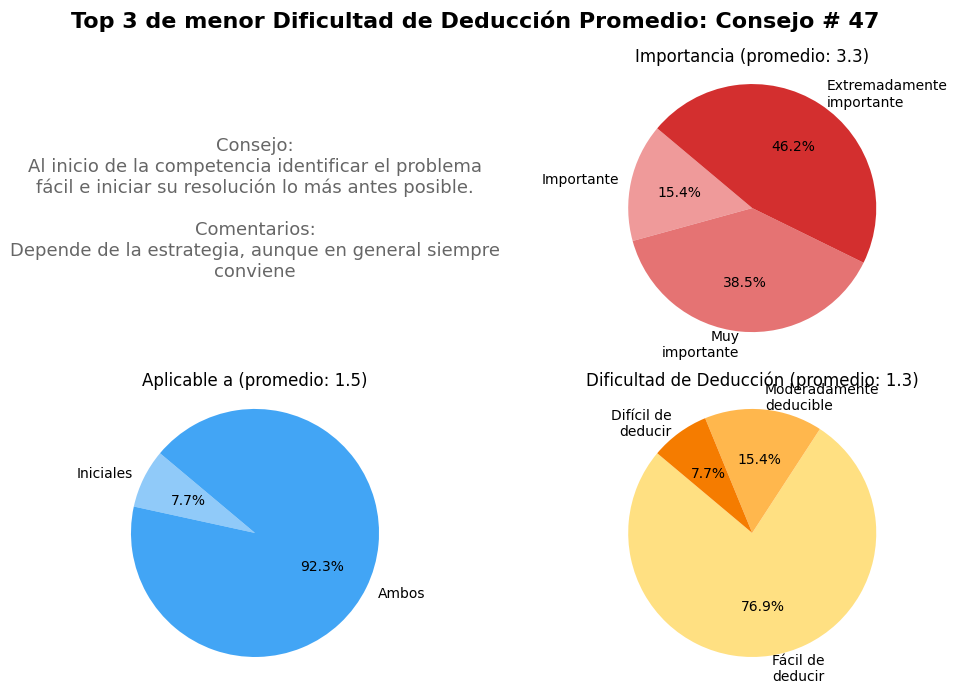

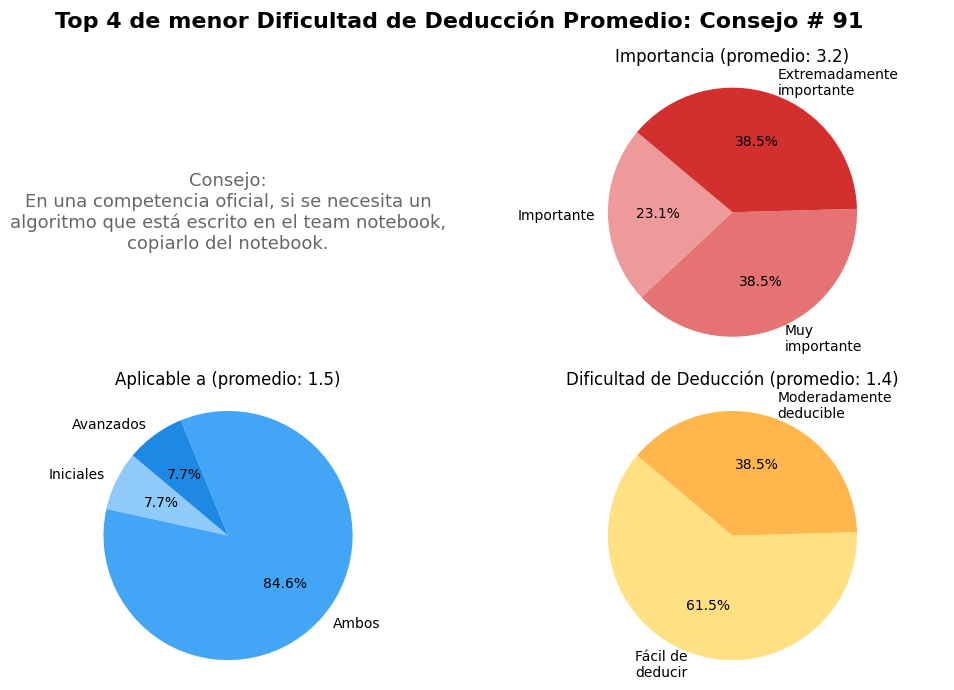

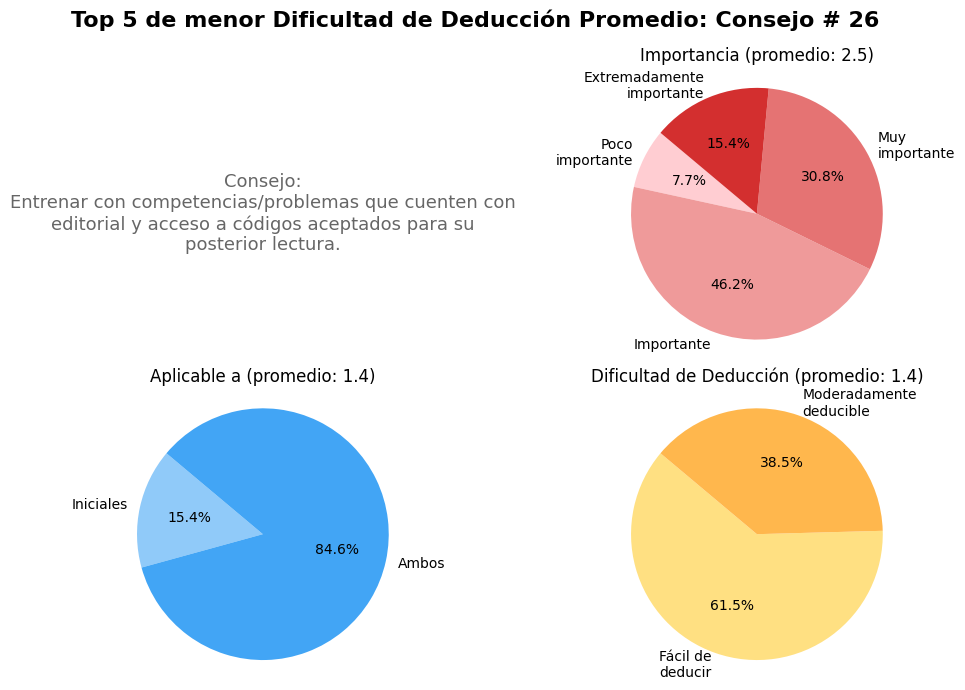

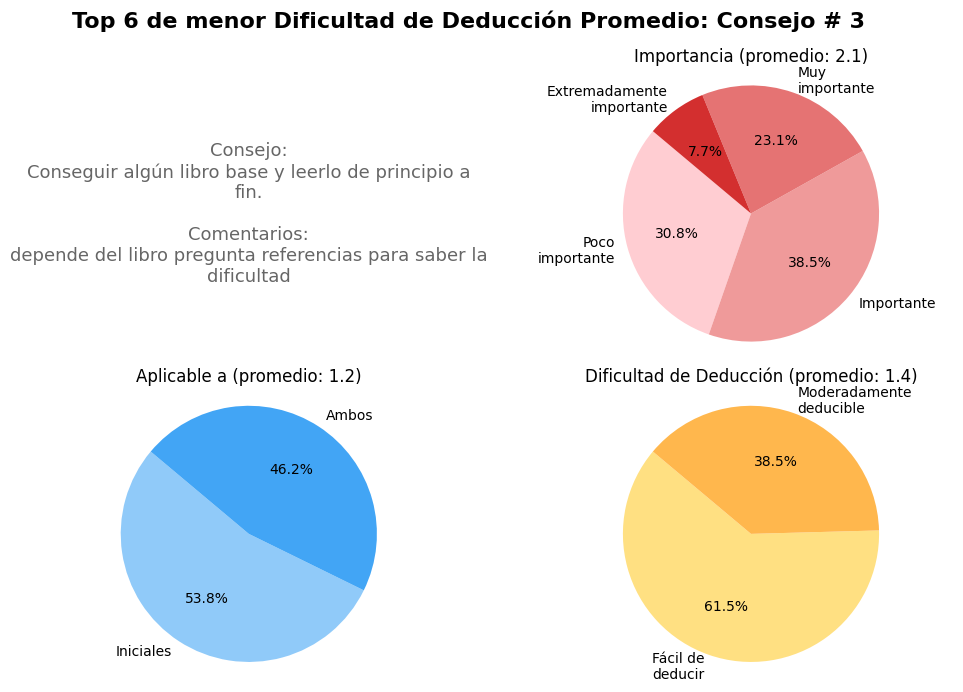

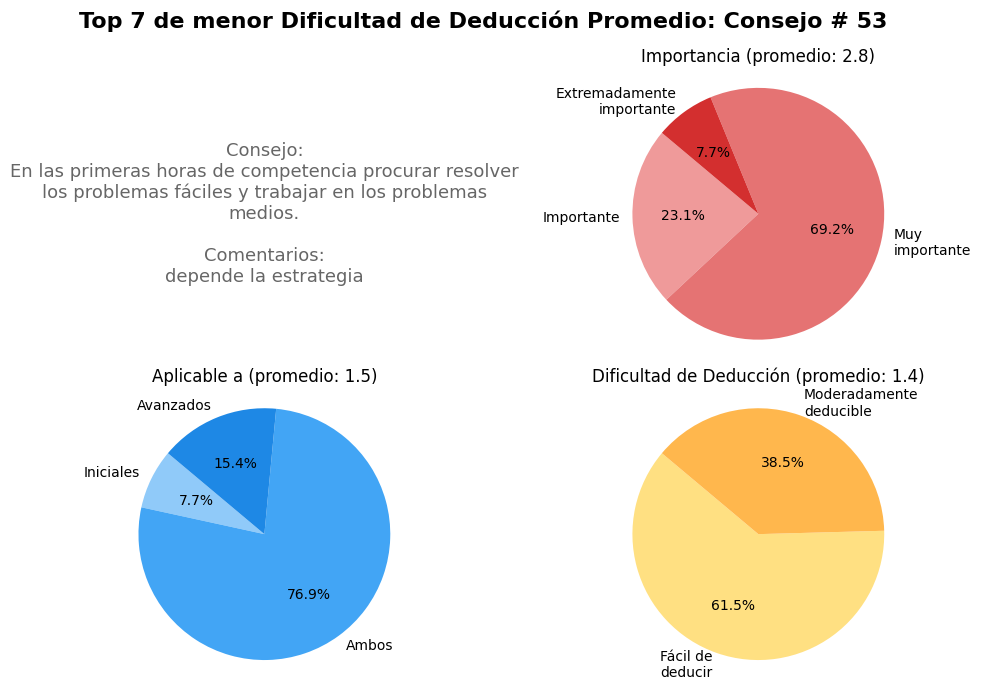

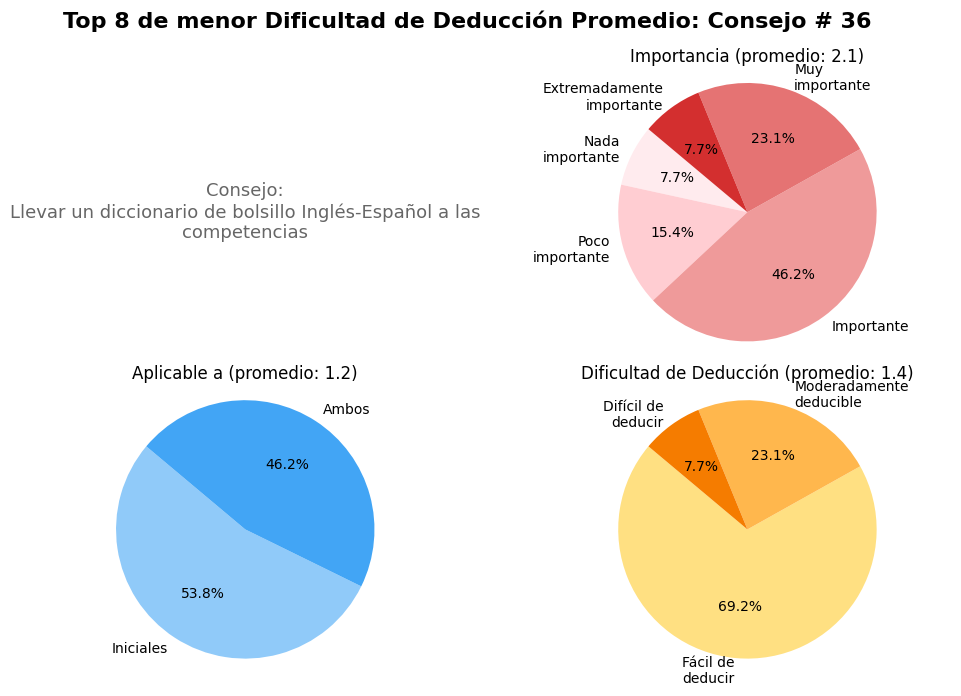

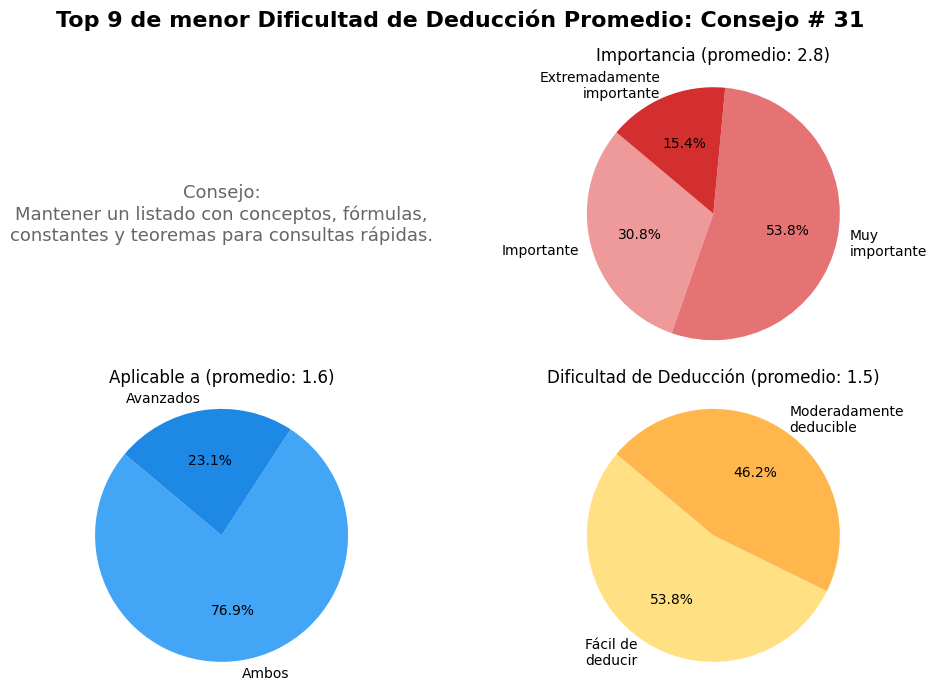

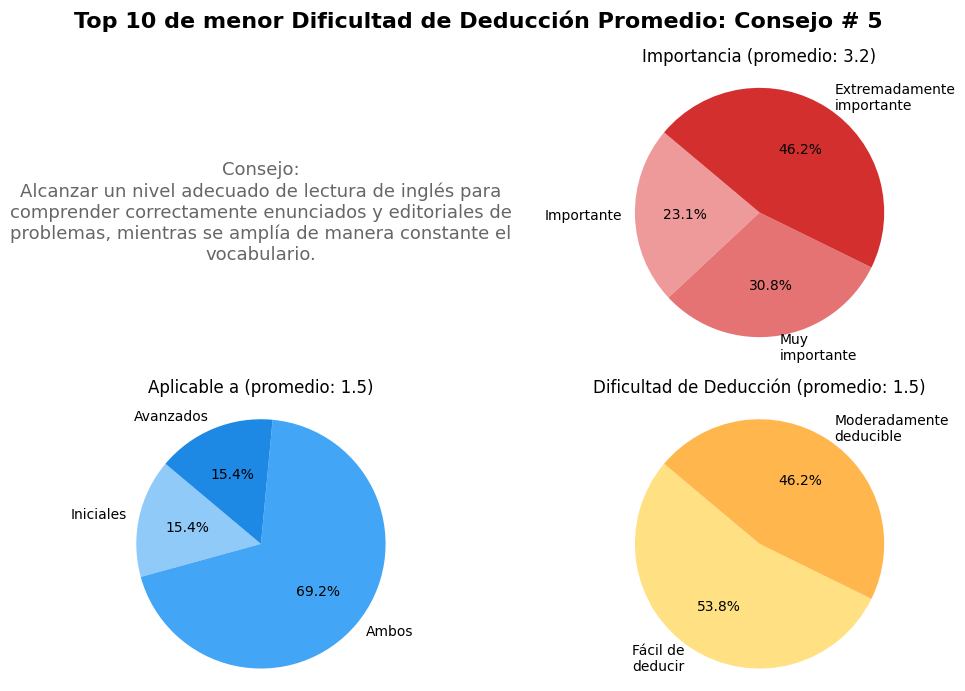

In [179]:
# Top 10 consejos con menor Dificultad de Deducción Promedio:
plot_top10_advice(advice_data, metric='Dificultad de Deducción Promedio', extreme="lowest")

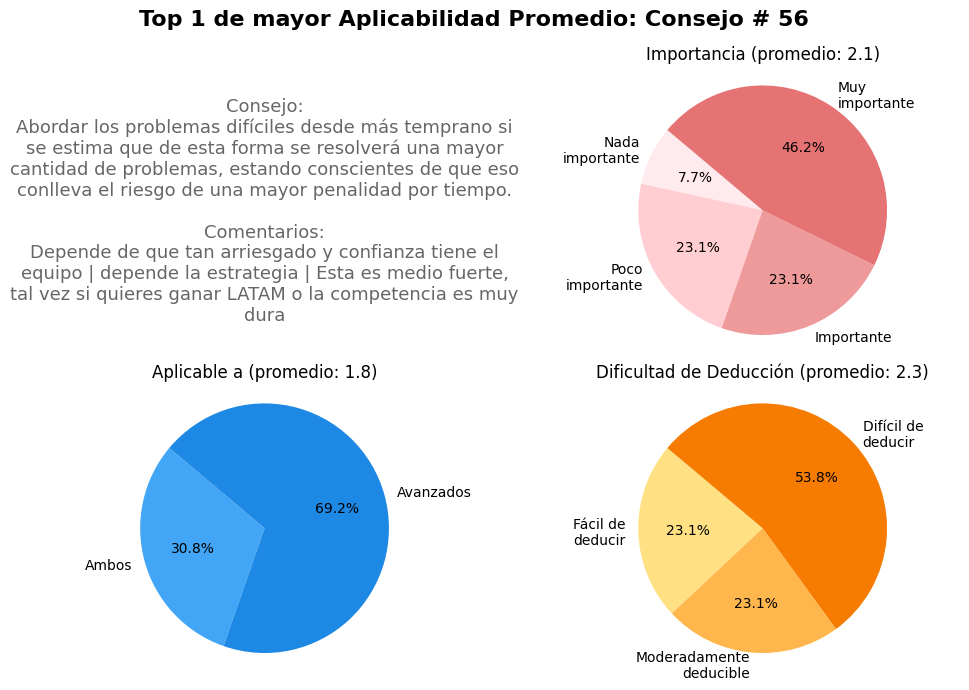

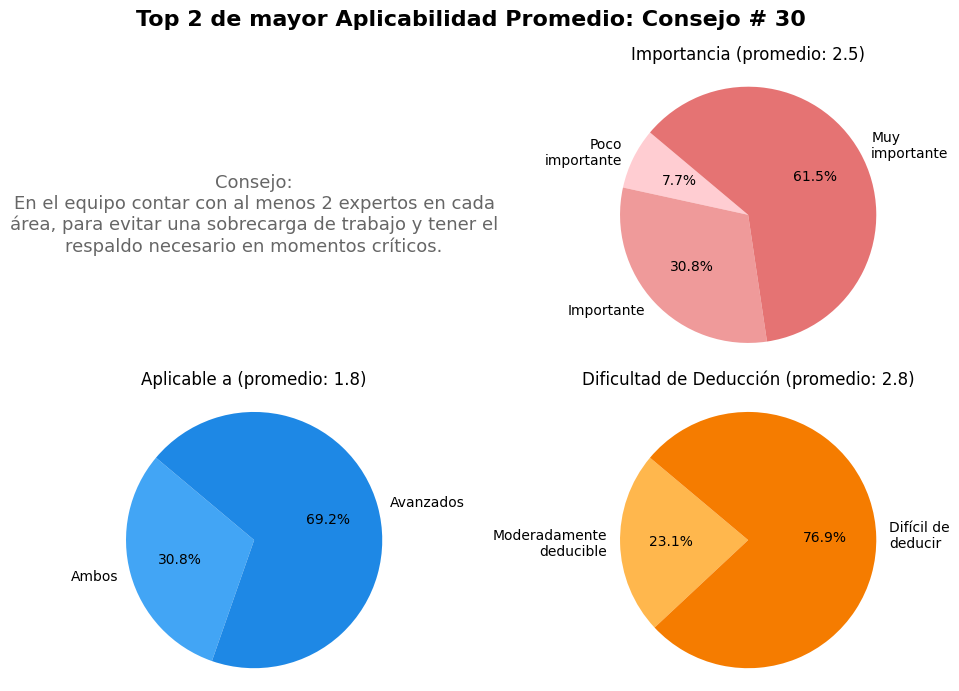

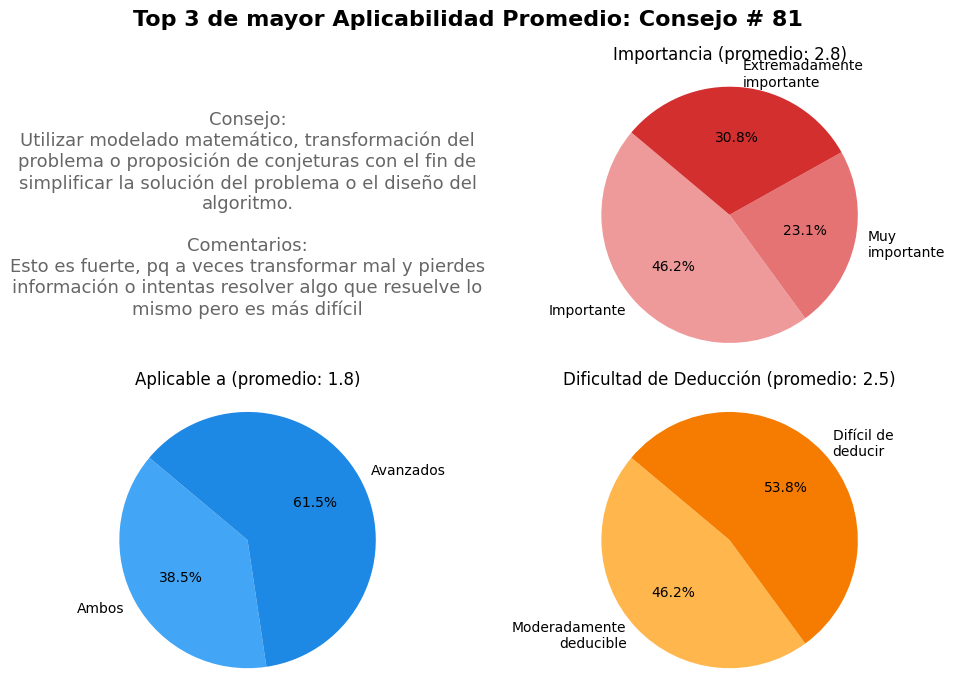

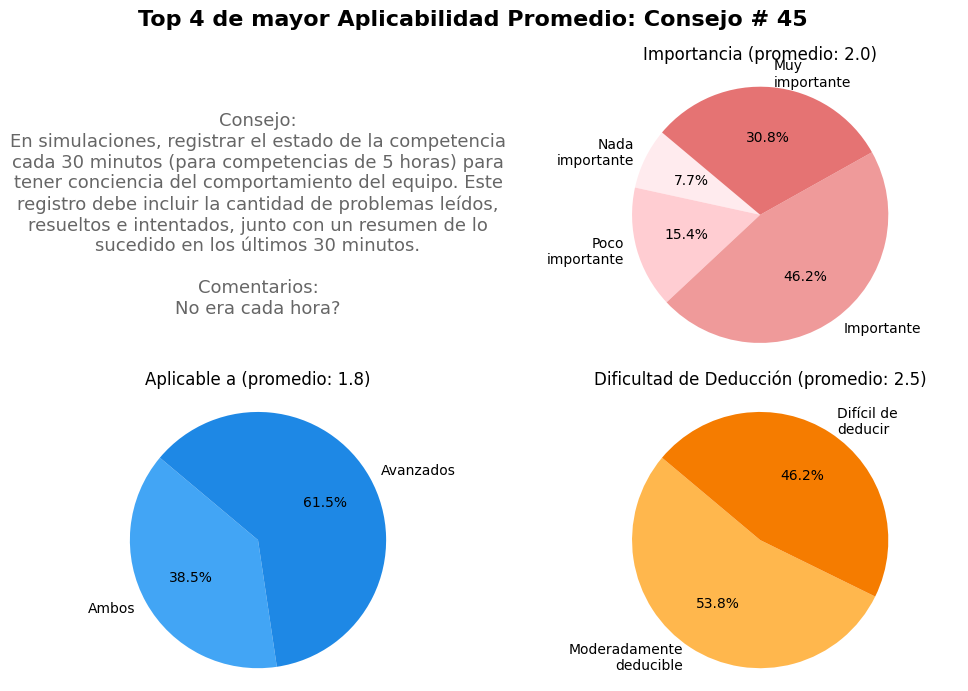

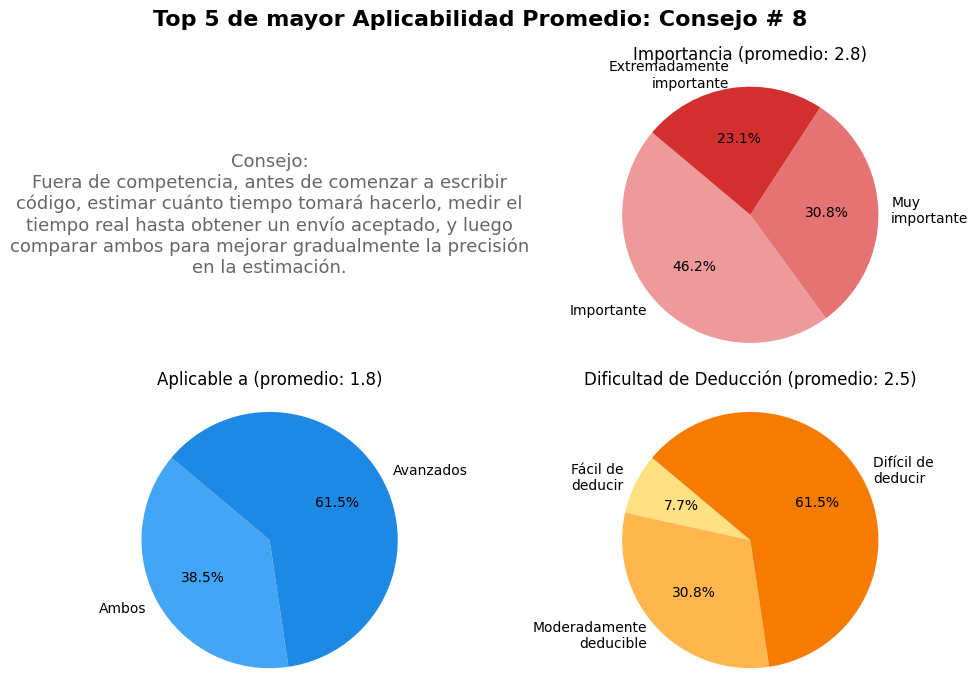

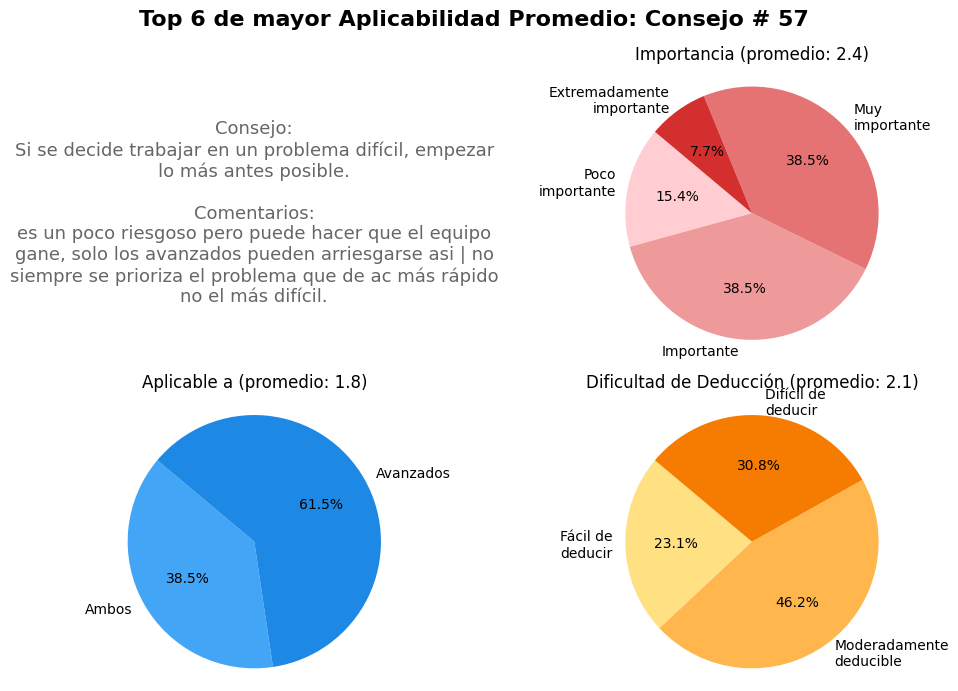

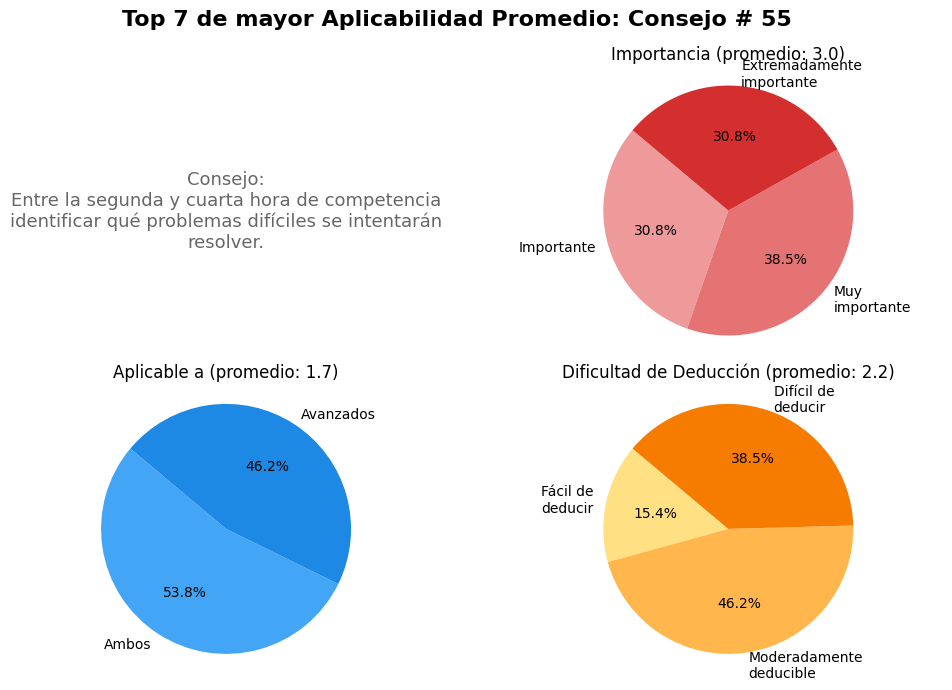

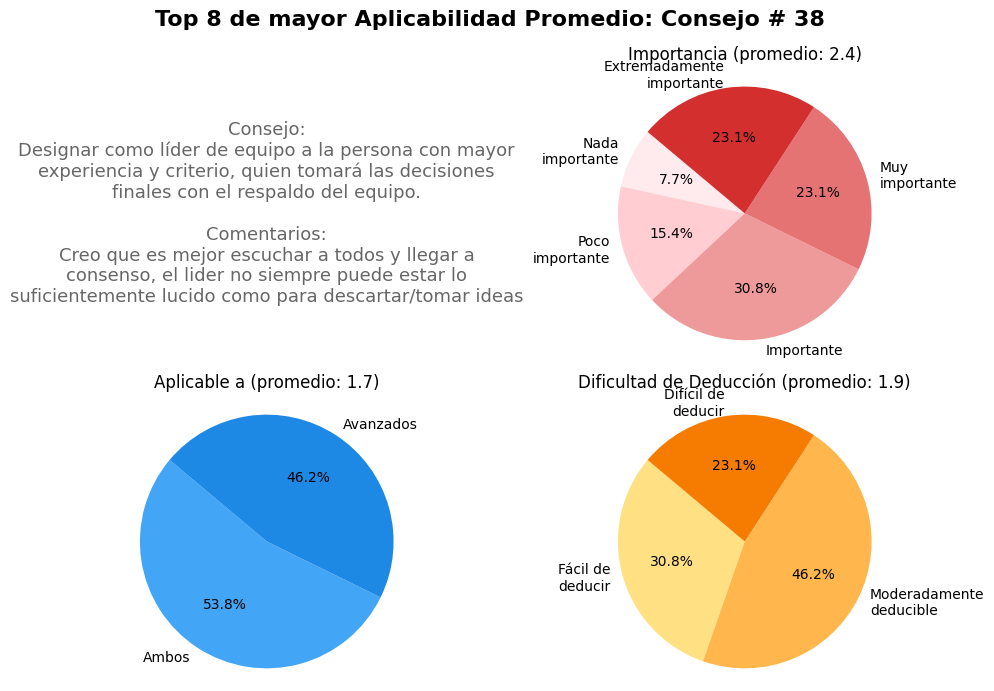

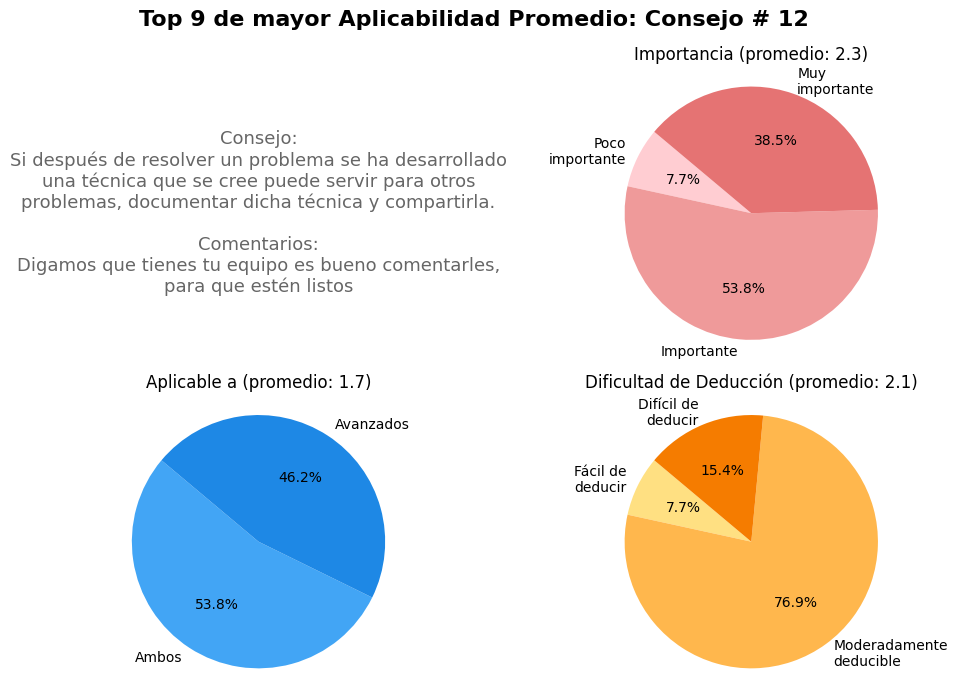

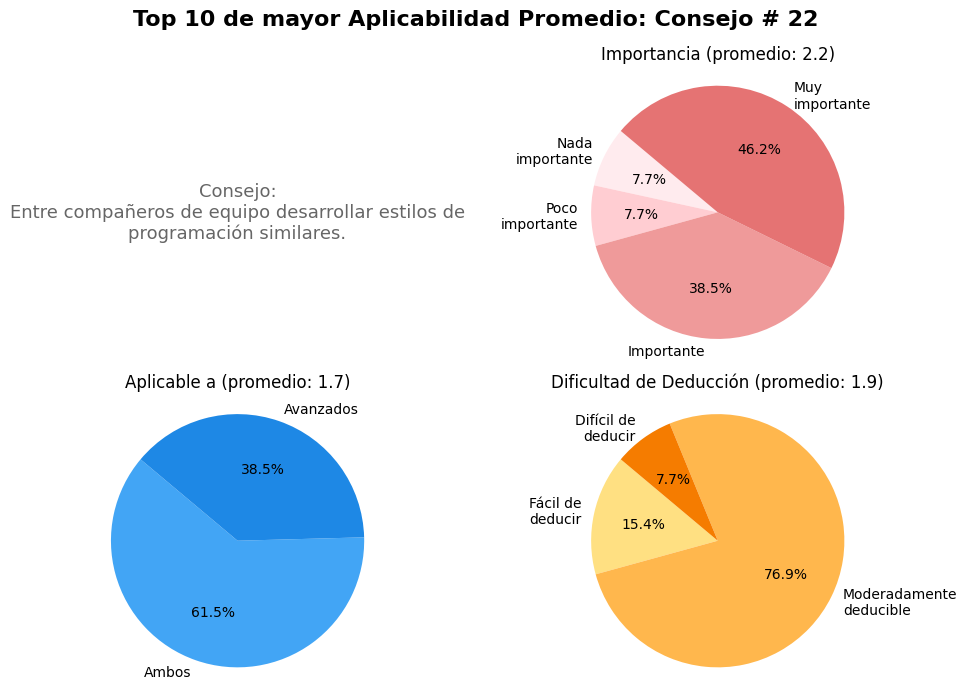

In [180]:
# Top 10 consejos con menor Aplicabilidad Promedio:
plot_top10_advice(advice_data, metric='Aplicabilidad Promedio', extreme="highest")

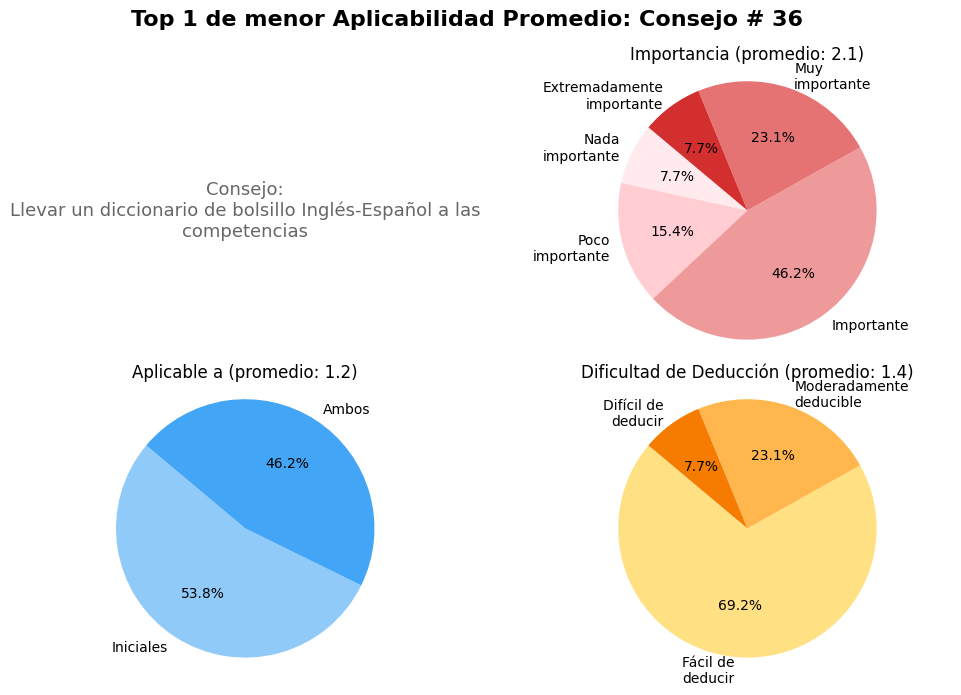

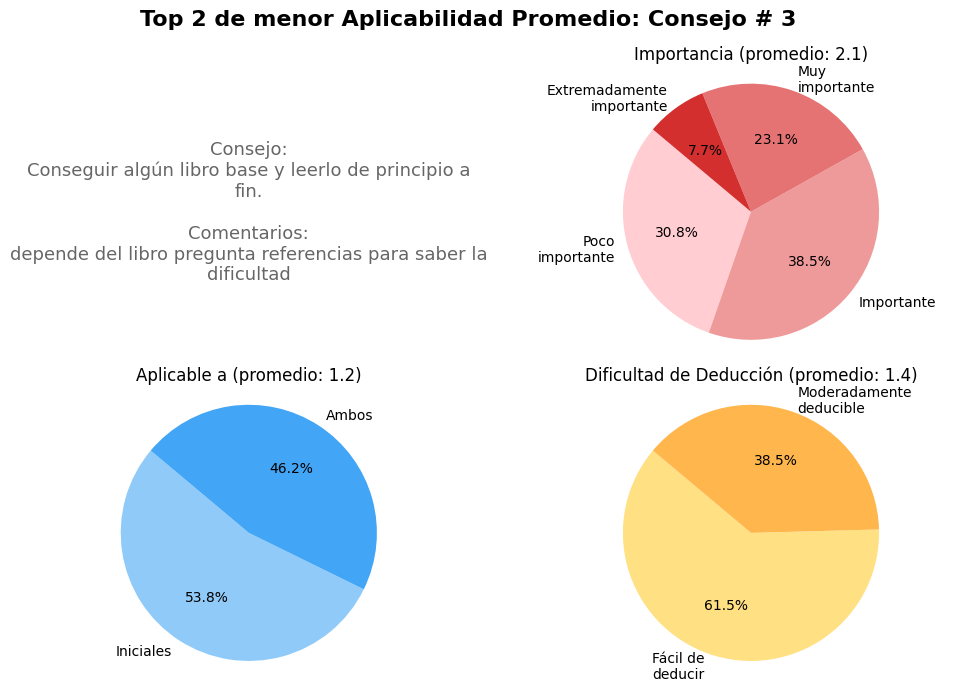

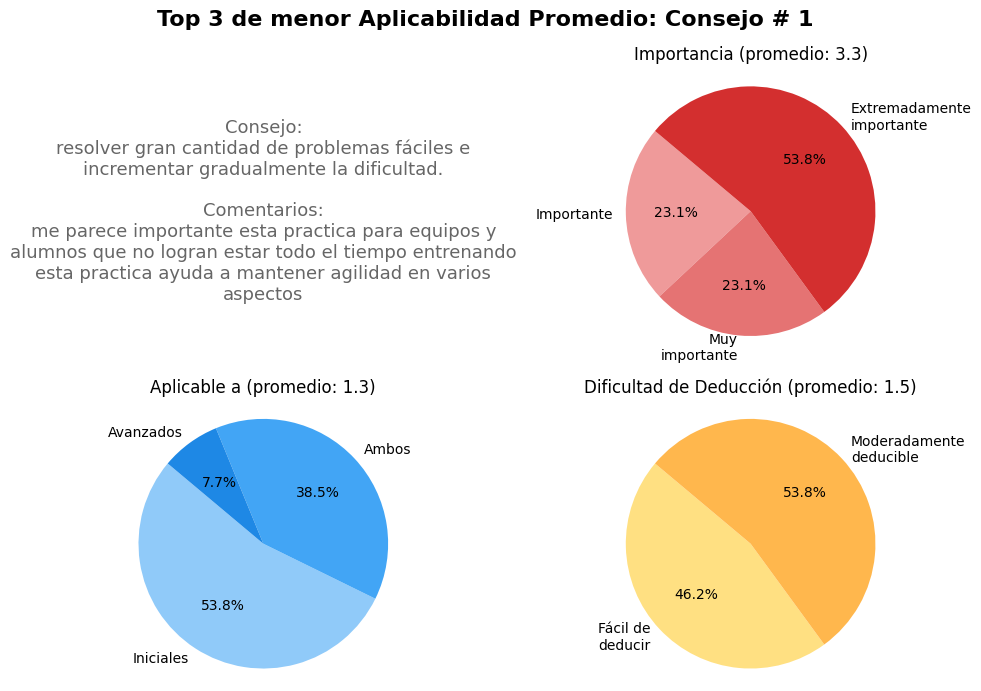

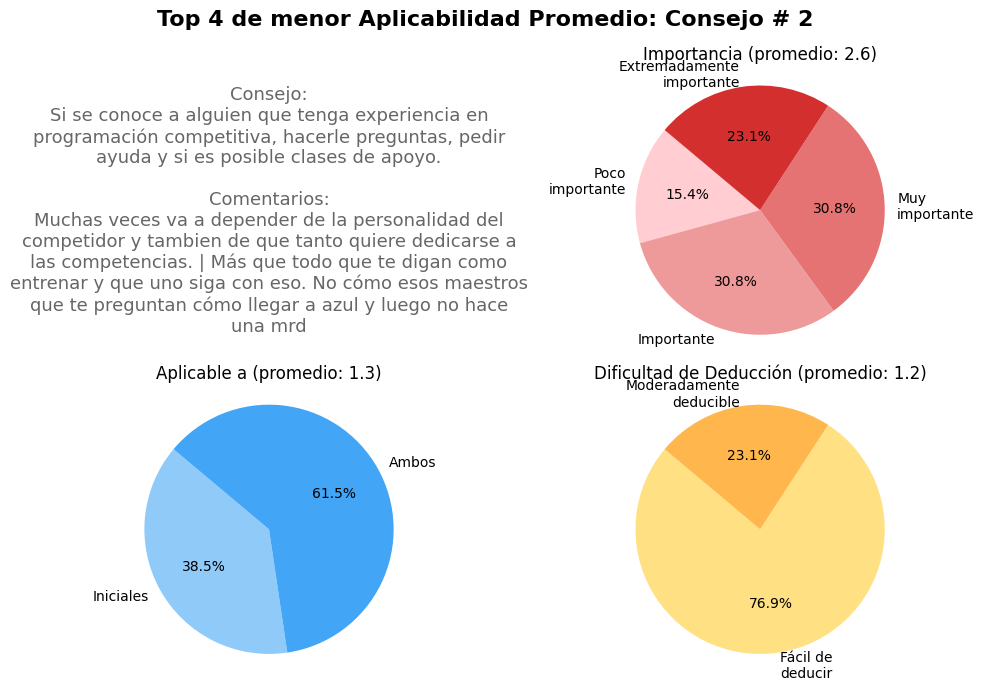

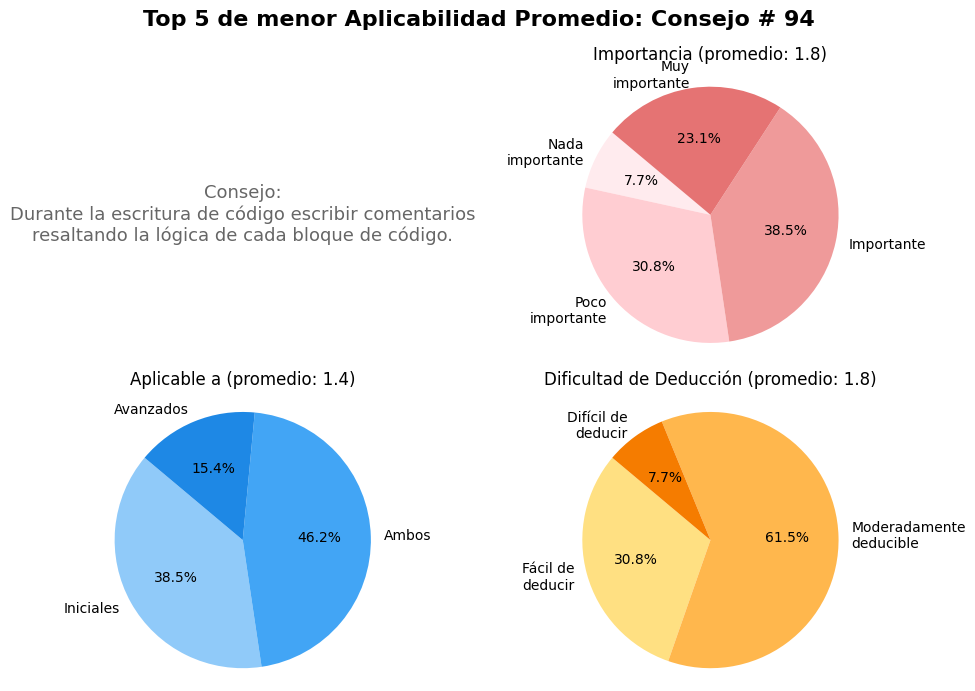

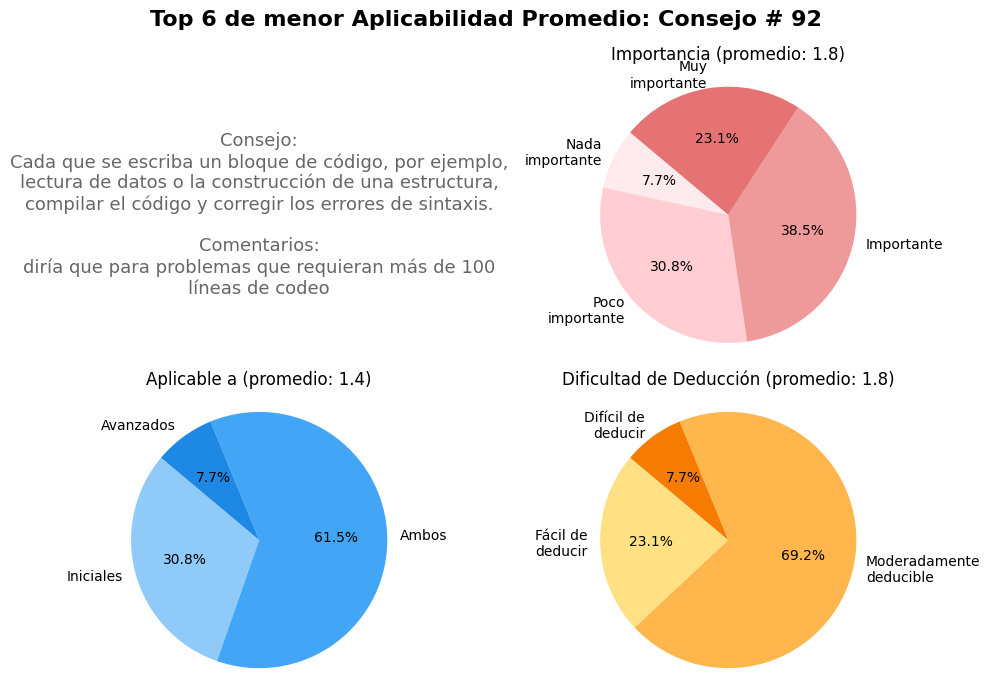

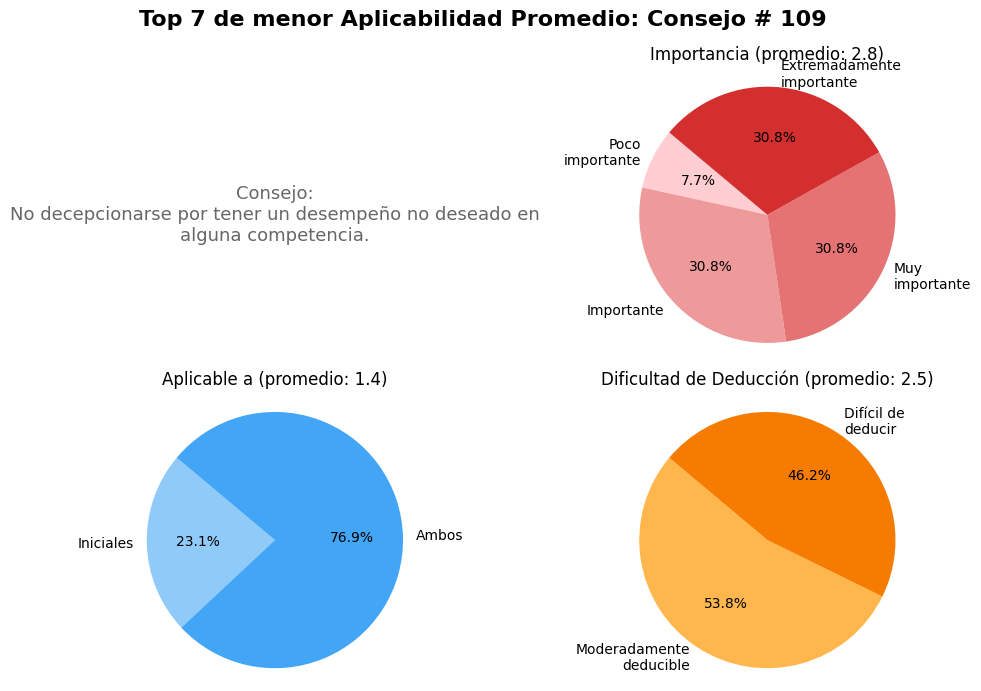

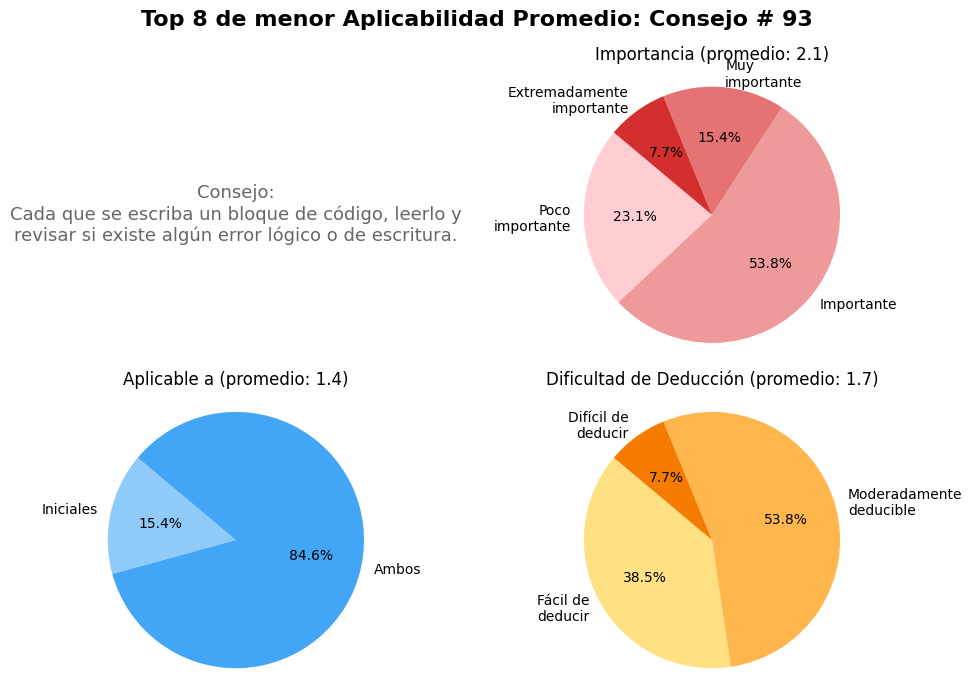

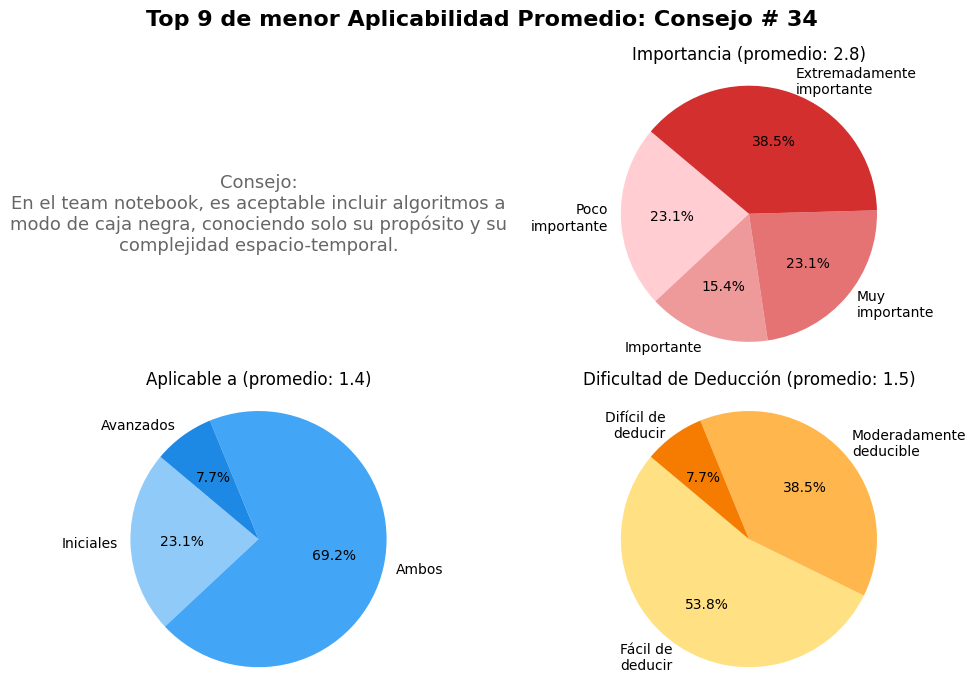

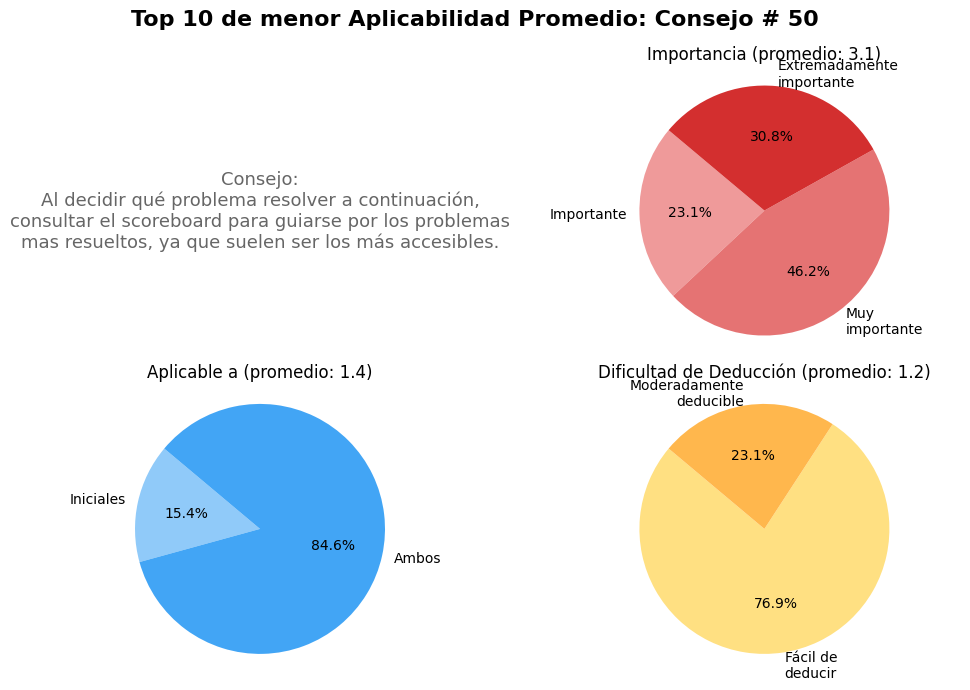

In [181]:
# Top 10 consejos con menor Aplicabilidad Promedio:
plot_top10_advice(advice_data, metric='Aplicabilidad Promedio', extreme="lowest")